In [1]:
import numpy as np
import pandas as pd
import datetime
import re
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from geopy.distance import geodesic
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
import webbrowser
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

Solving environment: done

# All requested packages already installed.



## Executive Summary 

This notebook consist of Exploratory data analysis (EDA). The findings in this notebook will be used in modelling and also used in drawing conclusion and recommendation. This notebook is made up of the follwing parts: Firstly data importation of training, spray and weather dataset. Next, the datasets will be inspected (looking at info, null values and describe etc). Follwing that, each feature will be explored in detail starting from address. We have separate the dataset into before spray (year 2007 and 2009) and after spray (2011 and 2013). This allows us to make comparison between the two time periods. Next, we looked into the mosquito species, time and trap. Lastly, we looked into weather.

The key findings are: 
1. The spray location was not targeted at where WNV was present 
2. Not all mosquitos carry WNV, certain species tend to have higher probability of carrying WNV
3. There are more mosquitos in 2007 compared to other years 
4. Culex Pipen was the most prevalent species in 2007 but it's population dropped drastically over the years
5. The overall trend of the mosquito population dropped over the years
6. July and August were the months where the mosquito population peaks 

### Contents:
- [1. Import Data](#1.-Import-Data)
- [2. Data Inspection & EDA](#2.-Data-Inspection-&-EDA)
- [3. Address](#3.-Address)
- [4. Looking at before spray year 2007 & 2009](#4.-Looking-at-before-spray-year-2007-&-2009)
- [5. After Spray 2011 & 2013](#5.-After-Spray-2011-&-2013)
- [6. Looking into Species of Mosquitos](#6.-Looking-into-Species-of-Mosquitos)
- [7. Looking into Time](#7.-Looking-into-Time)
- [8. Looking into Trap](#8.-Looking-into-Trap)
- [9. Weather](#9.-Weather)

## 1. Import Data

In [2]:
df_train = pd.read_csv("../data/train_modified_rows.csv")
df_train.head(3)

,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Date,NumMosquitos,WnvPresent,wnv_percent
0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0
1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0
2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0


In [3]:
df_train.reset_index(inplace=True) # set aside index col as record id for training data

In [4]:
df_train.shape

(114760, 15)

In [5]:
df_weather = pd.read_csv("../data/weather.csv")
df_weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [6]:
df_weather.shape

(2944, 22)

In [7]:
def date_reformat(row):
    date_string = row["Date"]
    date_obj = datetime.datetime.strptime(date_string, r"%Y-%m-%d")
    row["Year"] = date_obj.year
    row["Month"] = date_obj.month
    row["Day"] = date_obj.day
    row["Unix"] = unixtime = time.mktime(date_obj.timetuple())
    #print(row["Unix"])
    return row

In [8]:
df_train = df_train.apply(date_reformat, axis=1)

In [9]:
df_train.head()

,index,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Date,NumMosquitos,WnvPresent,wnv_percent,Year,Month,Day,Unix
0,0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0,2007,5,29,1.180368e+09
1,1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0,2007,5,29,1.180368e+09
2,2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09
3,3,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09
4,4,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09


In [10]:
df_spray = pd.read_csv("../data/spray.csv")

In [11]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [12]:
df_spray = df_spray.apply(date_reformat, axis=1)

In [13]:
df_spray.head()

,Date,Time,Latitude,Longitude,Year,Month,Day,Unix
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,1.314547e+09
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,1.314547e+09
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,1.314547e+09
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29,1.314547e+09
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29,1.314547e+09


## 2. Data Inspection & EDA

In [14]:
# The mean viruse present is 0.003982
# The mean mosiquito is 1.17 while the maximum is 2532 
df_train.describe()

,index,Unnamed: 0,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,wnv_percent,Year,Month,Day,Unix
count,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,114760.000000,1.147600e+05
mean,57379.500000,57379.500000,41.304636,41.848301,-87.692188,7.947020,1.176708,0.003982,0.003332,2009.442105,7.568421,15.968421,1.263140e+09
std,33128.502783,33128.502783,24.846122,0.106376,0.079328,1.254339,20.824584,0.062979,0.055732,2.232383,1.210943,9.082646,7.024562e+07
min,0.000000,0.000000,10.000000,41.644612,-87.930995,3.000000,0.000000,0.000000,0.000000,2007.000000,5.000000,1.000000,1.180368e+09
25%,28689.750000,28689.750000,18.000000,41.753391,-87.749149,8.000000,0.000000,0.000000,0.000000,2007.000000,7.000000,8.000000,1.188835e+09
50%,57379.500000,57379.500000,39.000000,41.857402,-87.694259,8.000000,0.000000,0.000000,0.000000,2009.000000,8.000000,16.000000,1.248365e+09
75%,86069.250000,86069.250000,61.000000,41.949830,-87.648064,9.000000,0.000000,0.000000,0.000000,2011.000000,9.000000,25.000000,1.314806e+09
max,114759.000000,114759.000000,98.000000,42.017430,-87.531635,9.000000,2532.000000,1.000000,1.000000,2013.000000,10.000000,31.000000,1.380125e+09


In [15]:
df_train.isna().sum()

index                     0
Unnamed: 0                0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
Date                      0
NumMosquitos              0
WnvPresent                0
wnv_percent               0
Year                      0
Month                     0
Day                       0
Unix                      0
dtype: int64

In [16]:
df_spray.describe()

,Latitude,Longitude,Year,Month,Day,Unix
count,14835.000000,14835.000000,14835.000000,14835.000000,14835.000000,1.483500e+04
mean,41.904828,-87.736690,2012.702191,7.948028,17.073812,1.367131e+09
std,0.104381,0.067292,0.712013,0.677402,7.959018,2.172388e+07
min,41.713925,-88.096468,2011.000000,7.000000,5.000000,1.314547e+09
25%,41.785001,-87.794225,2013.000000,7.000000,8.000000,1.373990e+09
50%,41.940075,-87.727853,2013.000000,8.000000,17.000000,1.376496e+09
75%,41.980978,-87.694108,2013.000000,8.000000,25.000000,1.377101e+09
max,42.395983,-87.586727,2013.000000,9.000000,29.000000,1.378310e+09


In [17]:
df_spray.isna().sum()

Date           0
Time         584
Latitude       0
Longitude      0
Year           0
Month          0
Day            0
Unix           0
dtype: int64

In [18]:
df_weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


### 3. Address

In [19]:
#plot the folium map for the locations which have the outbreaks for all years
map_year = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=10,width=750, height=400)

group0 = folium.FeatureGroup(name='<span style=\\"color: gold;\\">2007</span>')
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2007)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2007)]):
     folium.CircleMarker(
        [Latitude, Longitude],radius=5,color="gold",popup="2007"
        ).add_to(group0)
group0.add_to(map_year)
group1 = folium.FeatureGroup(name='<span style=\\"color: black;\\">2008</span>')
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2008)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2008)]):
     folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,color="black",popup="2008"
        ).add_to(group1)
group1.add_to(map_year)
group2 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">2009</span>')
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2009)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2009)]):
     folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,color="blue",popup="2009"
        ).add_to(group2)
group2.add_to(map_year)
group3 = folium.FeatureGroup(name='<span style=\\"color: pink;\\">2010</span>')
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2010)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2010)]):
     folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,color="pink",popup="2010"
        ).add_to(group3)
group3.add_to(map_year)
group4 = folium.FeatureGroup(name='<span style=\\"color: green;\\">2011</span>')       
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2011)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2011)]):
     folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,color="green",popup="2011"
        ).add_to(map_year)
group4.add_to(map_year)
group5 = folium.FeatureGroup(name='<span style=\\"color: purple;\\">2012</span>')       
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2012)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2012)]):
     folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,color="purple",popup="2012",
        ).add_to(group5)
group5.add_to(map_year)
group6 = folium.FeatureGroup(name='<span style=\\"color: red;\\">2013</span>')
for Latitude, Longitude in zip(df_train["Latitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2013)],\
                     df_train["Longitude"][(df_train["WnvPresent"]==1) & (df_train["Year"]==2013)]):
     folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,color="red",popup="2013",
     ).add_to(group6)
group6.add_to(map_year)



folium.map.LayerControl('topright', collapsed=False).add_to(map_year)

map_year

### 4. Looking at before spray year 2007 & 2009

In [20]:
mask = (df_train['Year']==2007 )|(df_train['Year']==2009)

In [21]:
df_train_before = df_train.loc[mask]

In [22]:
df_train_before.head()

,index,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Date,NumMosquitos,WnvPresent,wnv_percent,Year,Month,Day,Unix
0,0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0,2007,5,29,1.180368e+09
1,1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0,2007,5,29,1.180368e+09
2,2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09
3,3,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09
4,4,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09


In [23]:
# Number of unique trap 2007 and 2009
len(df_train_before['Trap'].unique())

151

In [24]:
# 2007, 2009 most number of trap are T115 and T900
df_train_before['Trap'].value_counts().sort_values(ascending=False)

T099     472
T090A    472
T222     472
T082     472
T142     472
        ... 
T200     472
T035     472
T063     472
T034     472
T218B    472
Name: Trap, Length: 151, dtype: int64

In [25]:
# Trap that caught most number of mosquitos 
df_train_before.groupby('Trap').NumMosquitos.sum().sort_values(ascending=False).head()

Trap
T115    19663
T138     9415
T900     5488
T103     2988
T128     2604
Name: NumMosquitos, dtype: int64

In [26]:
# Trap that caught most number of mosquitos with virus 
df_train_before.groupby('Trap').WnvPresent.sum().sort_values(ascending=False).head()

Trap
T115    12
T138     9
T002     8
T011     8
T086     7
Name: WnvPresent, dtype: int64

In [27]:
# Seems most of the virus were in south doty avenue 
df_train_before[df_train_before['Trap']=='T115']['Address'].value_counts()

South Doty Avenue, Chicago, IL, USA    472
Name: Address, dtype: int64

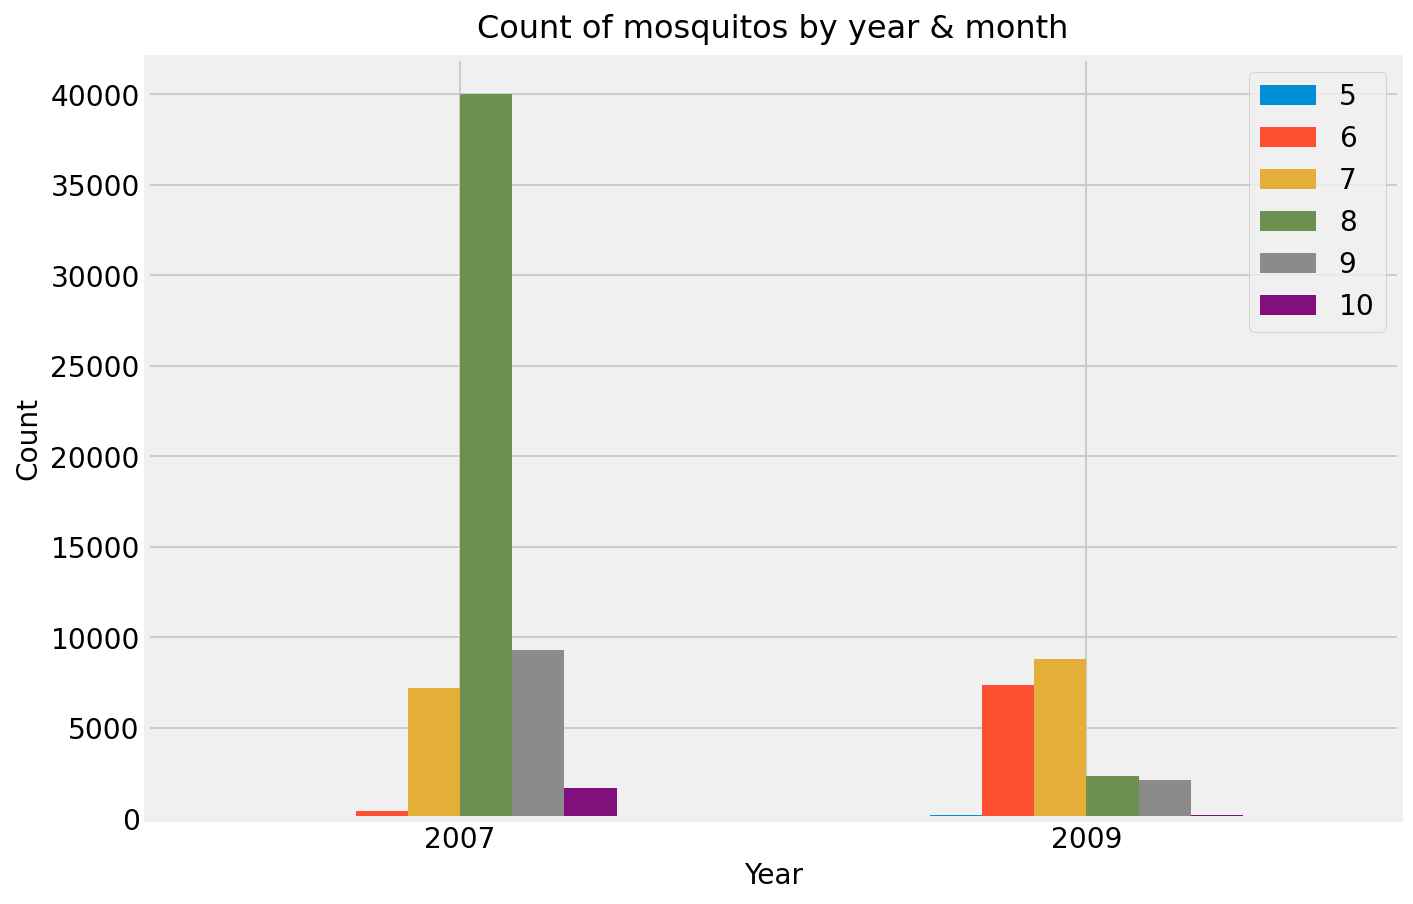

In [28]:
# Number of Mosquitos by Year and Month
df_train_before.groupby(['Year','Month']).NumMosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by year & month', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

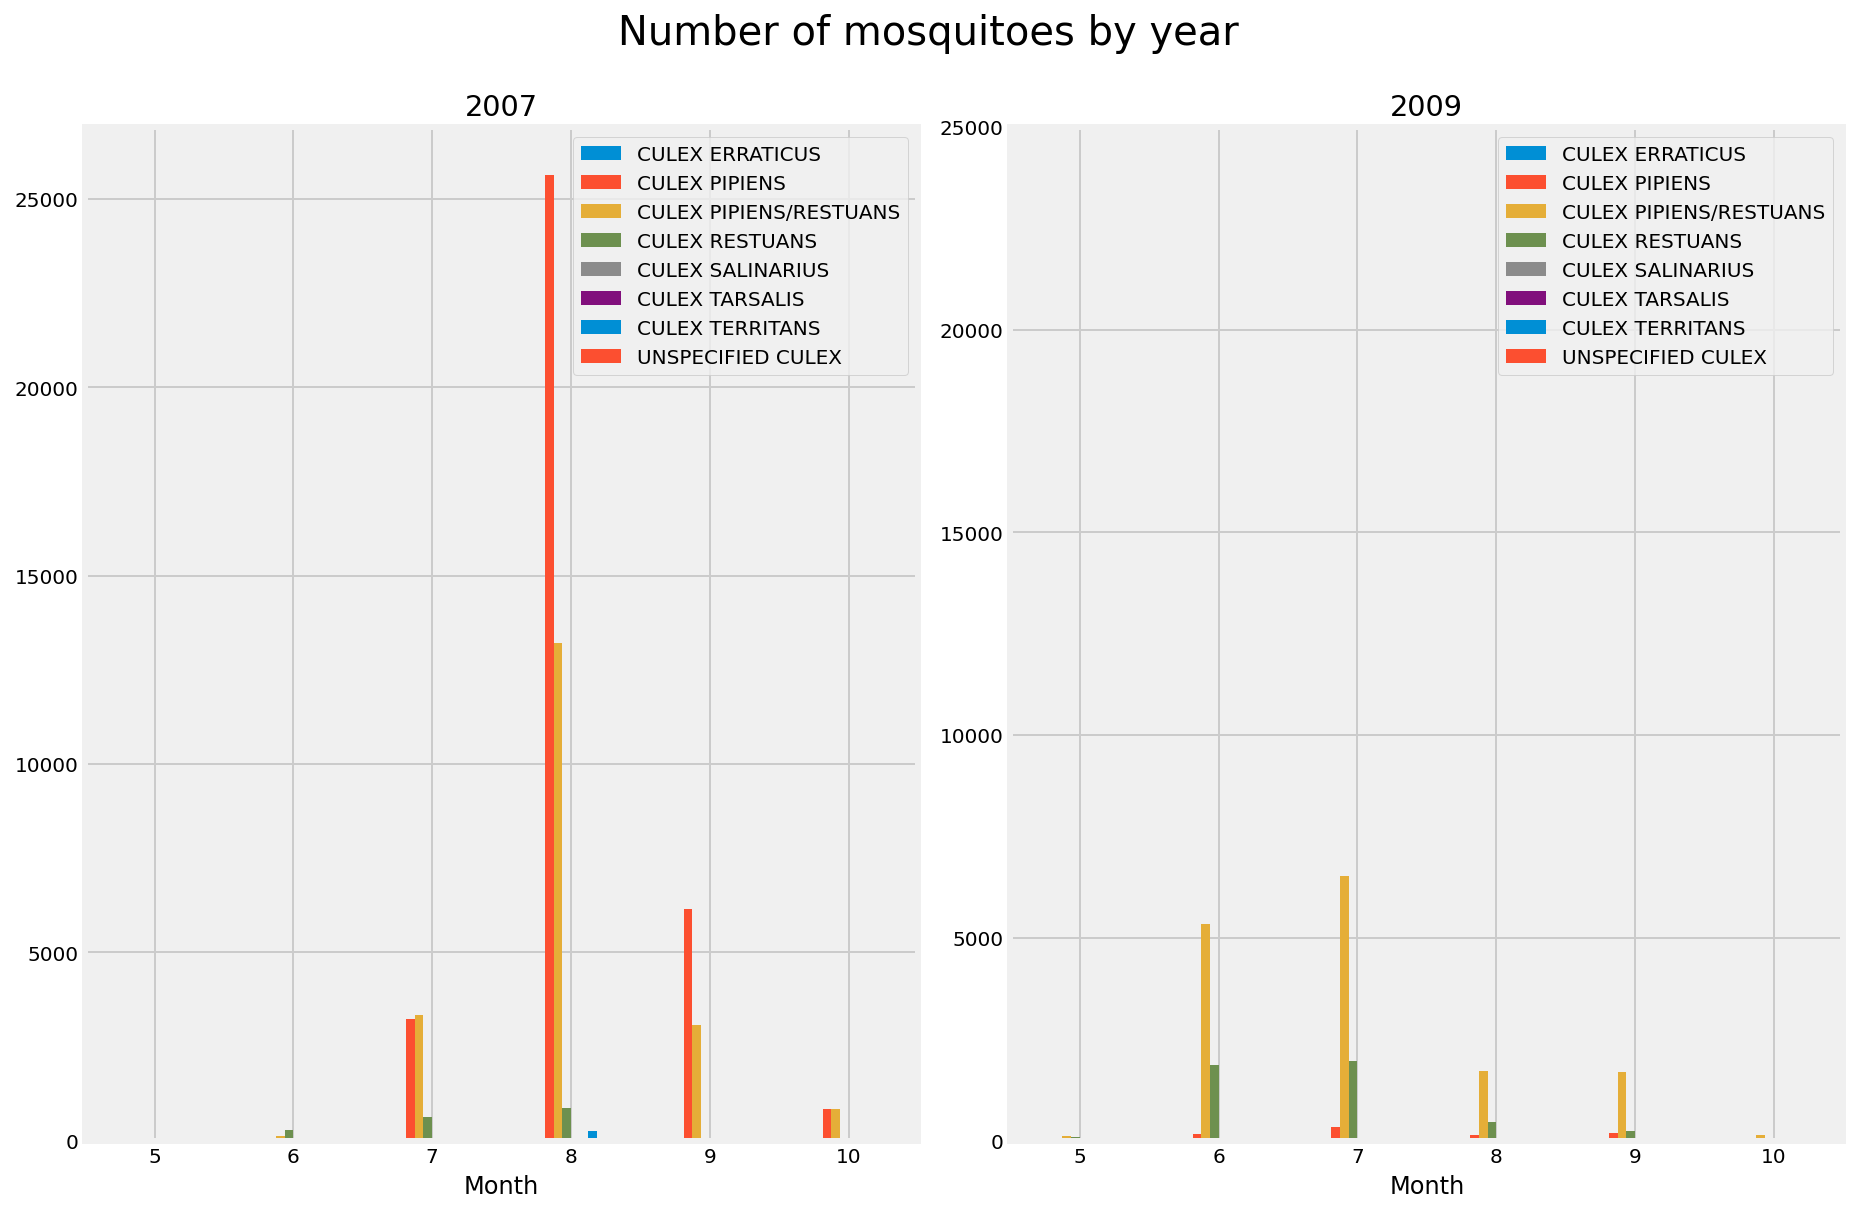

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,8))
ax = ax.ravel()
plt.suptitle('Number of mosquitoes by year', fontsize=20, y=1.05)
plt.ylim(0,25000)
for i, y in enumerate(df_train_before.Year.unique()):
    df_train_before[df_train_before['Year']==y].groupby(['Month', 'Species']).NumMosquitos.sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
    ax[i].legend(loc='upper right')
plt.tight_layout()

### 5. After Spray 2011 & 2013

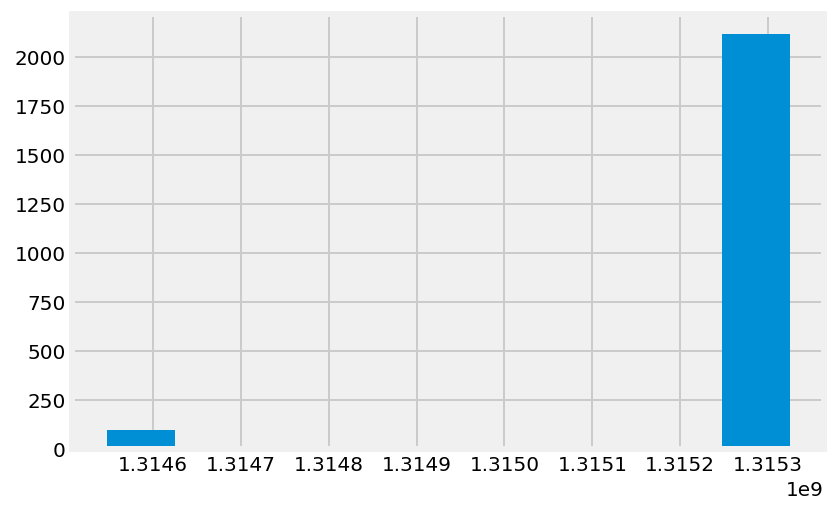

In [30]:
# for 2011
df_spray[df_spray["Year"] == 2011]["Unix"].hist()

In [31]:
df_spray[df_spray["Year"] == 2011]["Date"].value_counts()

2011-09-07    2114
2011-08-29      95
Name: Date, dtype: int64

In [32]:
df_spray[df_spray["Year"] == 2013]["Date"].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
Name: Date, dtype: int64

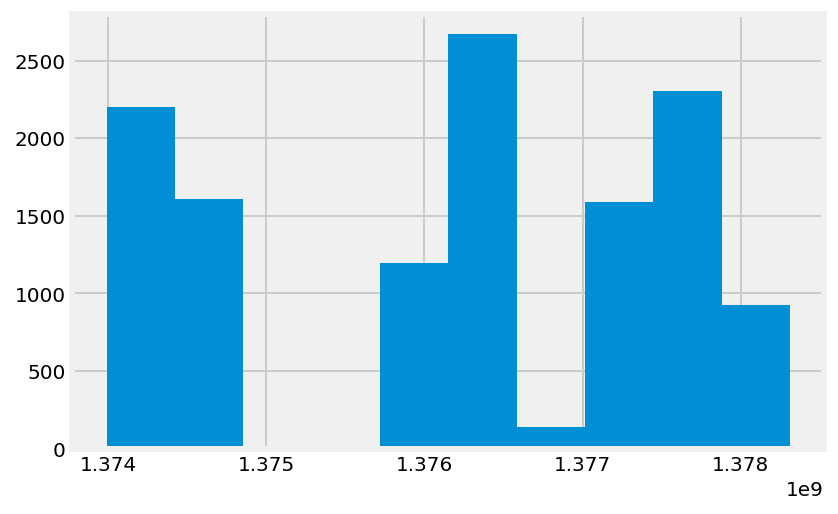

In [33]:
# plot the distribution of spray times
df_spray[df_spray["Year"] == 2013]["Unix"].hist()

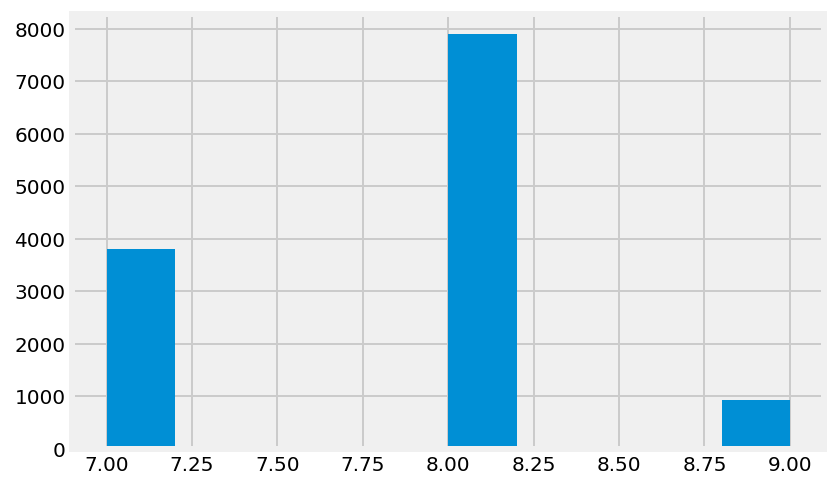

In [34]:
df_spray[df_spray["Year"] == 2013]["Month"].hist()

In [35]:
traps_2011 = pd.DataFrame(df_train[df_train["Year"] == 2011]["Trap"].value_counts().index,
                          columns=["Trap"])

traps_2013 = pd.DataFrame(df_train[df_train["Year"] == 2013]["Trap"].value_counts().index,
                          columns=["Trap"])

traps_2013.head()

,Trap
0,T011
1,T033
2,T049
3,T135
4,T227


In [36]:
print(df_train[df_train["Trap"] == "T009"]["Latitude"].value_counts())
print(df_train[df_train["Trap"] == "T009"]["Longitude"].value_counts())

print(df_train[df_train["Trap"] == "T009"]["Address"].value_counts())

41.992478    760
Name: Latitude, dtype: int64
-87.862995    760
Name: Longitude, dtype: int64
9100 West Higgins Road, Rosemont, IL 60018, USA    760
Name: Address, dtype: int64


In [37]:
print(df_train[df_train["Trap"] == "T035"]["Latitude"].value_counts())
print(df_train[df_train["Trap"] == "T035"]["Longitude"].value_counts())

print(df_train[df_train["Trap"] == "T035"]["Address"].value_counts())

41.763733    760
Name: Latitude, dtype: int64
-87.742302    760
Name: Longitude, dtype: int64
5100 West 72nd Street, Chicago, IL 60638, USA    760
Name: Address, dtype: int64


In [38]:
traps_2011 = pd.DataFrame(df_train[df_train["Year"] == 2011]["Trap"].value_counts().index,
                          columns=["Trap"])

In [39]:
traps_2013 = pd.DataFrame(df_train[df_train["Year"] == 2013]["Trap"].value_counts().index,
                          columns=["Trap"])

In [40]:
traps_2011.head(3)

,Trap
0,T011
1,T033
2,T049


In [41]:
def get_lat_long(row):
    trap_name = row["Trap"]
    
    # get the latitude and longitude
    lat = df_train[df_train["Trap"] == trap_name]["Latitude"].iloc[0]
    long = df_train[df_train["Trap"] == trap_name]["Longitude"].iloc[0]
    #print(lat)
    #print(long)
    #print(type(lat))
    row["Latitude"] = lat
    row["Longitude"] = long
    
    return row

In [42]:
traps_2011 = traps_2011.apply(get_lat_long, axis=1)
traps_2013 = traps_2013.apply(get_lat_long, axis=1)
traps_2011.head()

,Trap,Latitude,Longitude
0,T011,41.944869,-87.832763
1,T033,41.906638,-87.701431
2,T049,41.896282,-87.655232
3,T135,41.662014,-87.724608
4,T227,41.728495,-87.600963


In [43]:
# Look at the spray locations dataframe again and split it into years
df_spray.head(3)

,Date,Time,Latitude,Longitude,Year,Month,Day,Unix
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,1.314547e+09
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,1.314547e+09
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,1.314547e+09


In [44]:
sprays_2011 = df_spray[df_spray["Year"]== 2011]
sprays_2011.head()

,Date,Time,Latitude,Longitude,Year,Month,Day,Unix
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,1.314547e+09
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,1.314547e+09
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,1.314547e+09
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29,1.314547e+09
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29,1.314547e+09


In [45]:
sprays_2013 = df_spray[df_spray["Year"]== 2013]
sprays_2013.head()

,Date,Time,Latitude,Longitude,Year,Month,Day,Unix
2209,2013-07-17,7:45:45 PM,41.997728,-87.767532,2013,7,17,1.373990e+09
2210,2013-07-17,7:45:55 PM,41.997990,-87.768085,2013,7,17,1.373990e+09
2211,2013-07-17,7:46:05 PM,41.998237,-87.768623,2013,7,17,1.373990e+09
2212,2013-07-17,7:46:15 PM,41.998510,-87.769225,2013,7,17,1.373990e+09
2213,2013-07-17,7:46:25 PM,41.998793,-87.769833,2013,7,17,1.373990e+09


Text(0.5, 1.0, 'Spray (blue) vs Trap (orange & green) Locations')

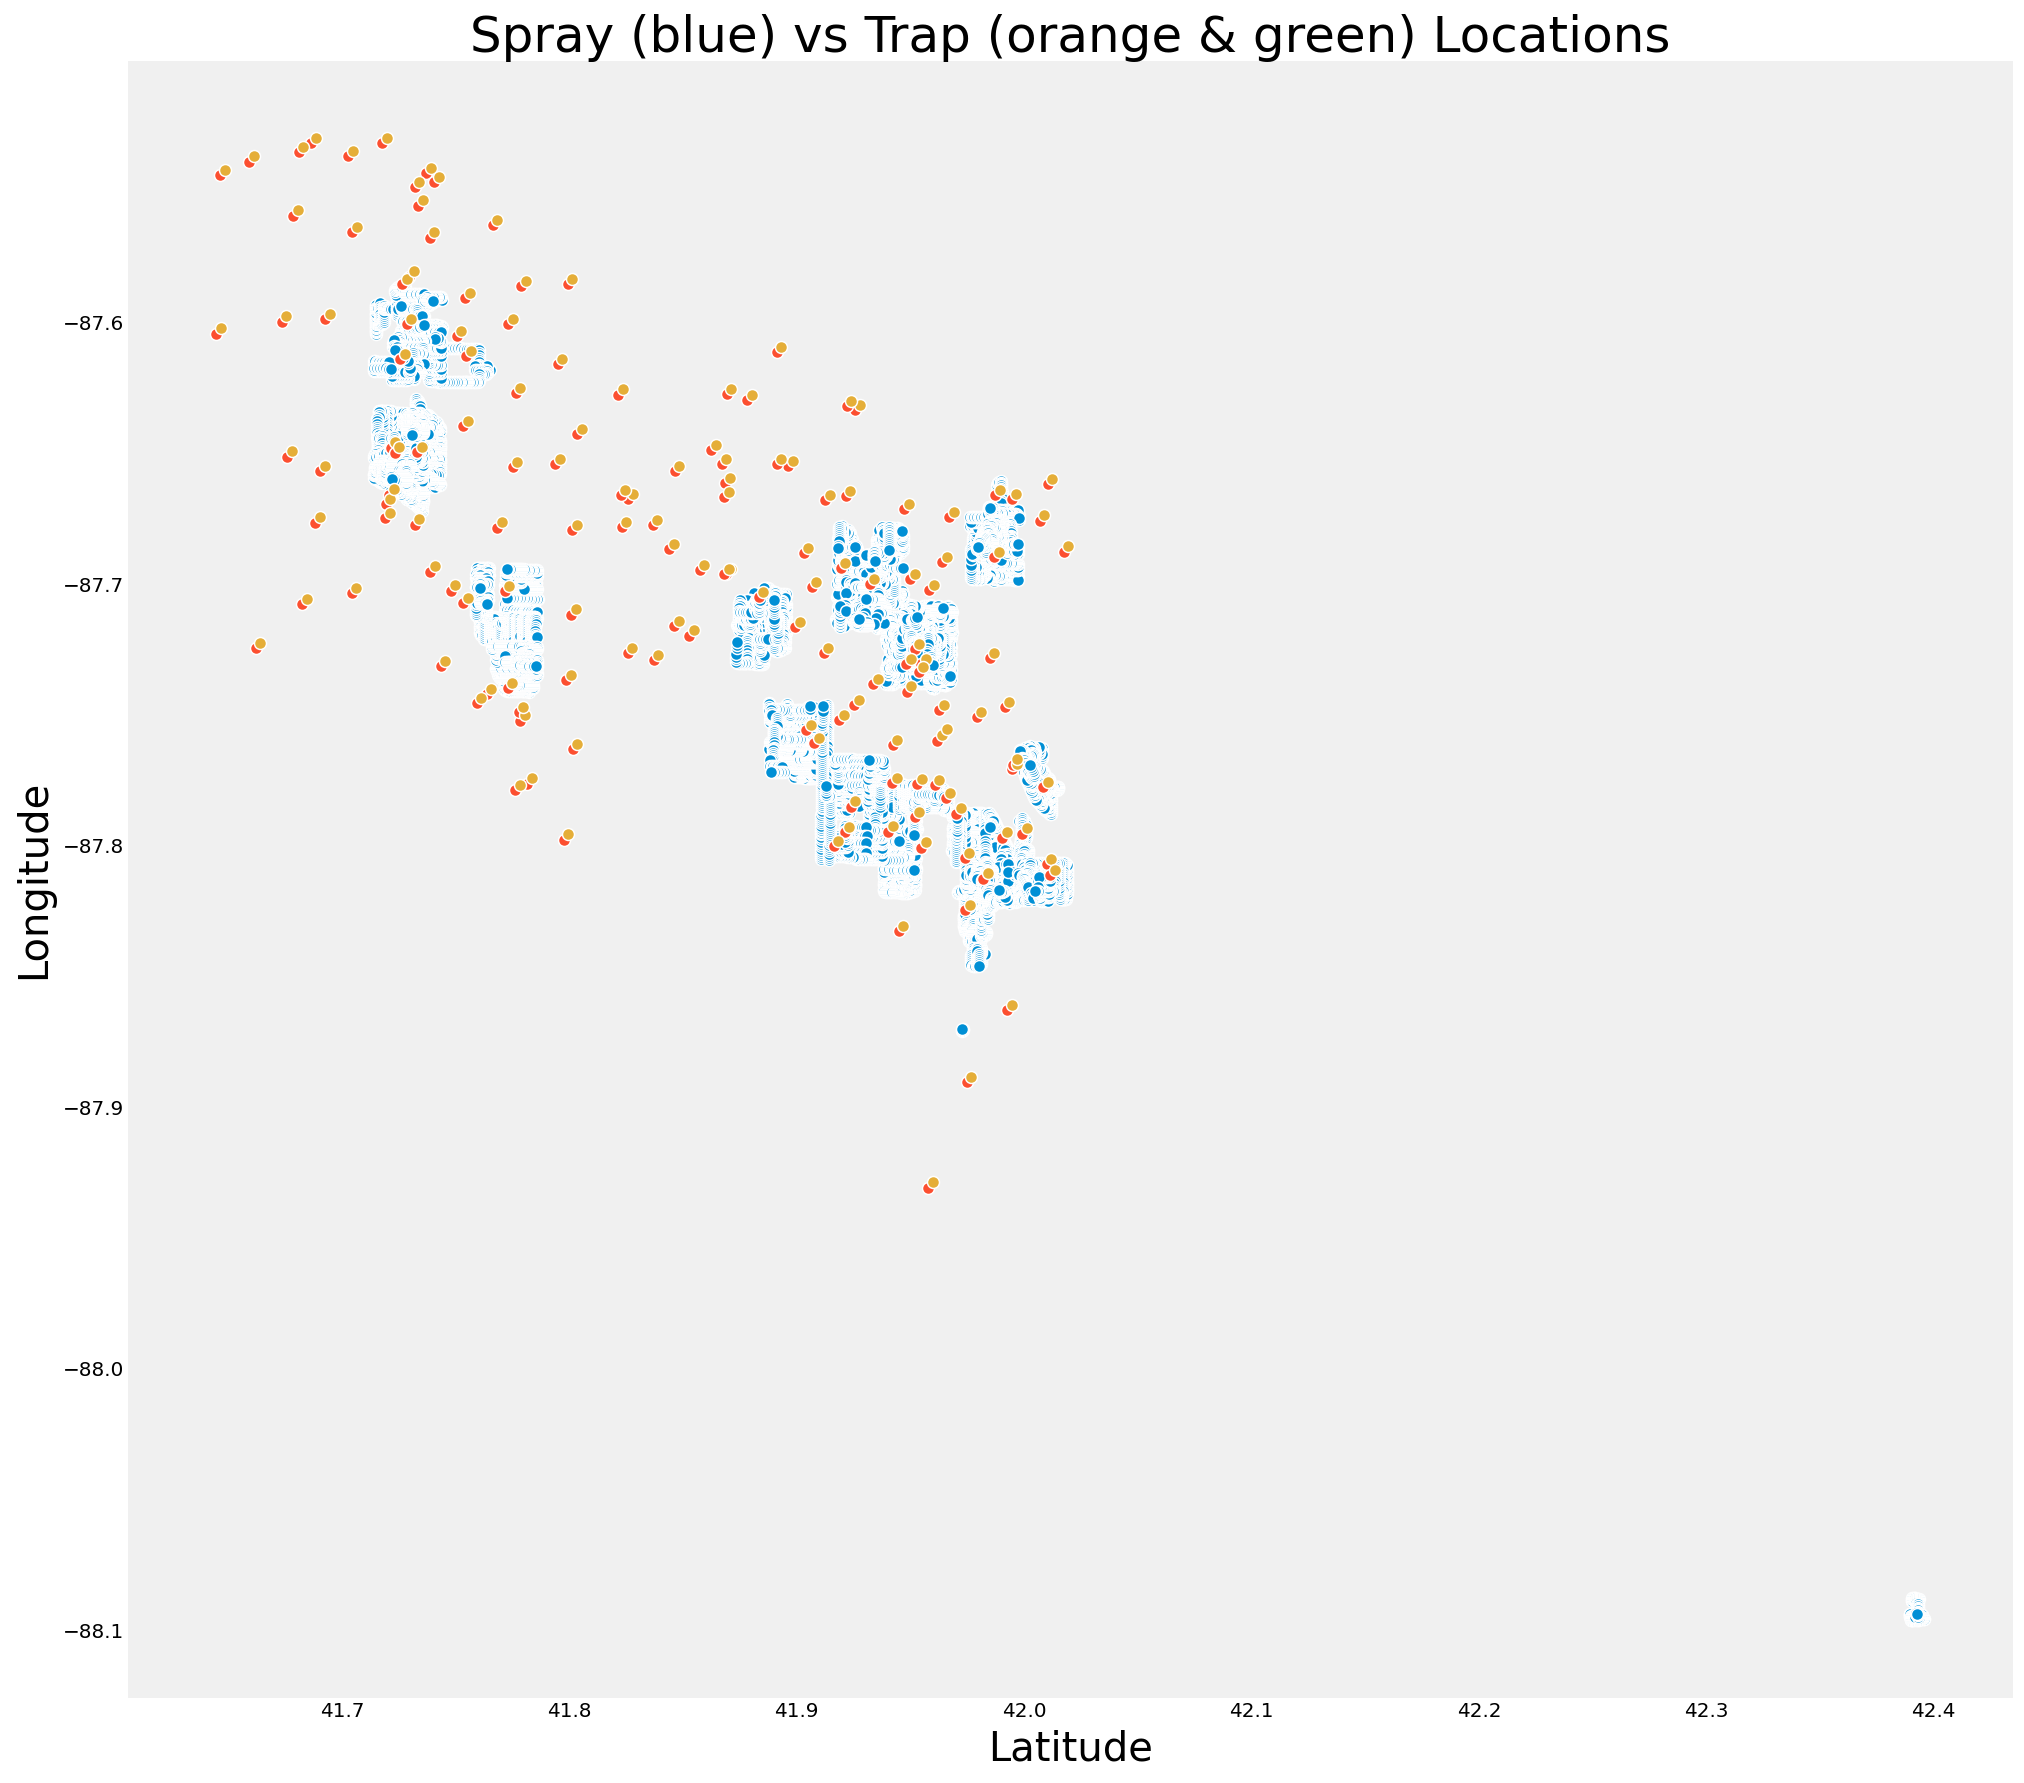

In [46]:
# Plot the spraying locations and the trap locations on one plot
plt.figure(figsize=(15,15))
plt.grid()
sns.scatterplot(df_spray["Latitude"], df_spray["Longitude"])
sns.scatterplot(traps_2011["Latitude"], traps_2011["Longitude"])
sns.scatterplot(traps_2013["Latitude"]+0.002, traps_2013["Longitude"]+0.002)

plt.xlabel("Latitude", fontdict={"size" : 20})
plt.ylabel("Longitude", fontdict={"size" : 20})
plt.title("Spray (blue) vs Trap (orange & green) Locations", fontdict={"size" : 25})

Text(0.5, 1.0, 'Spray (blue) vs Trap (orange) locations: 2011 only')

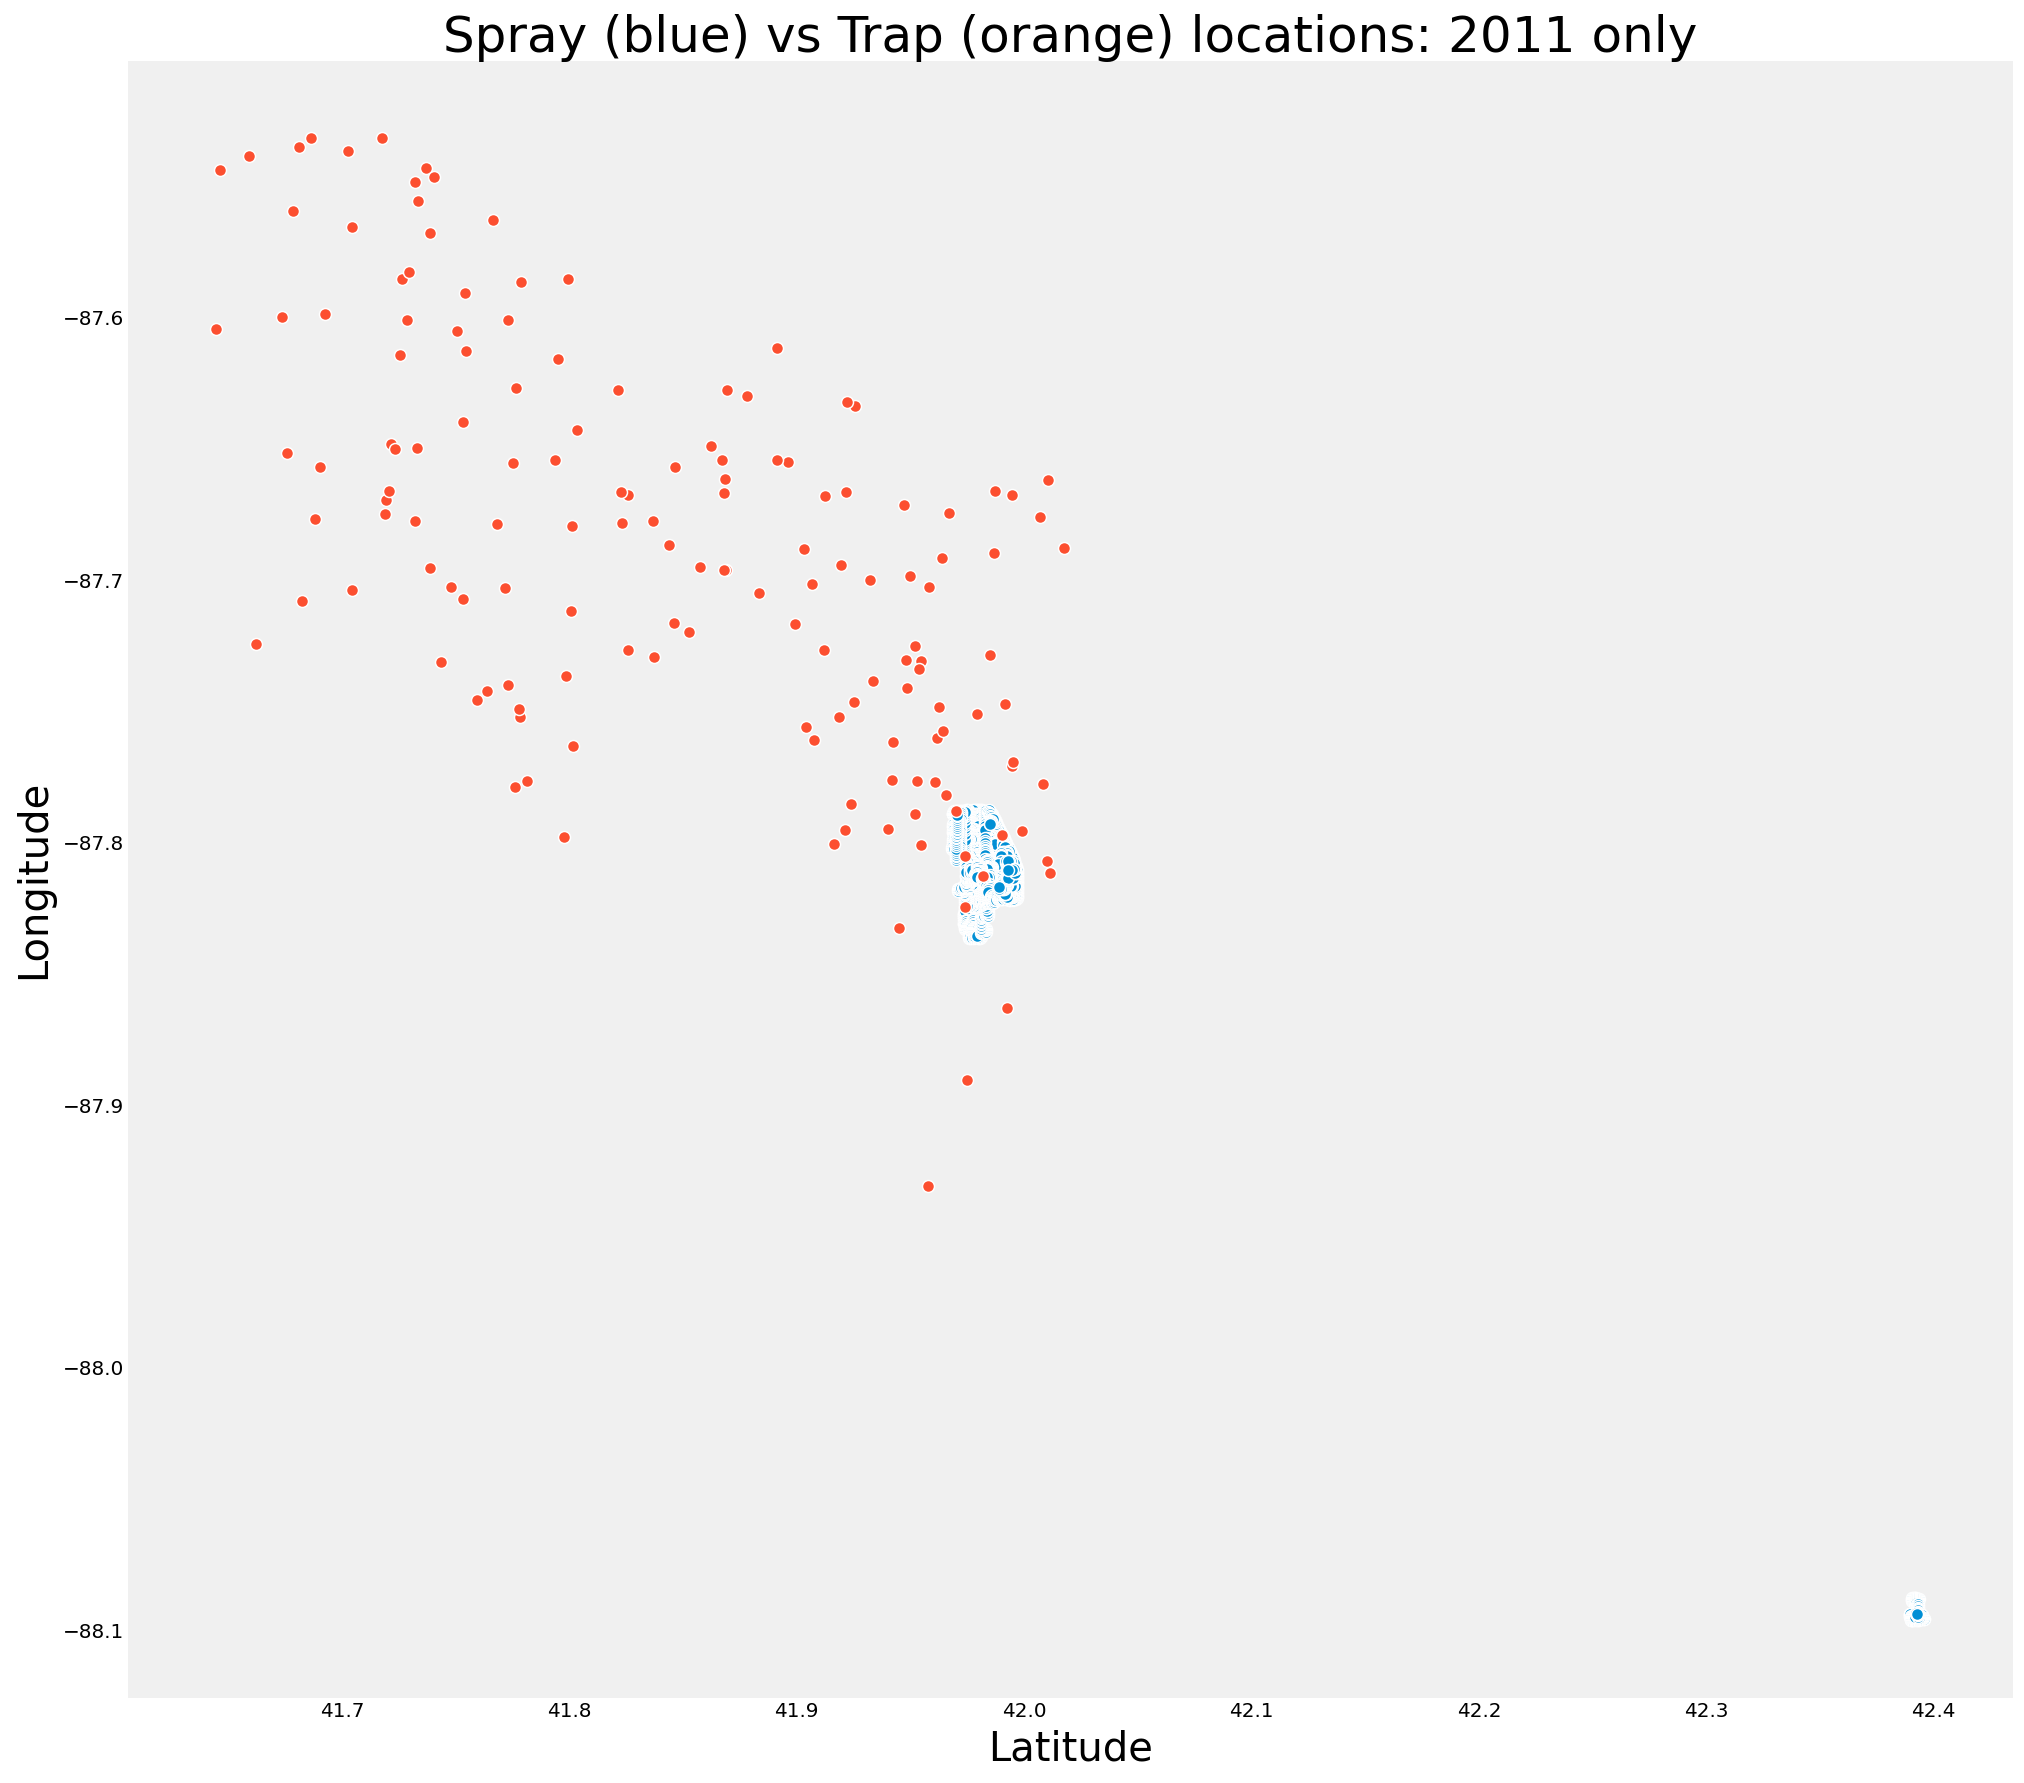

In [47]:
# Also note that 2011 only had a few sprays, and they are all in 2 areas
# and only one of which has a trap
plt.figure(figsize=(15,15))
plt.grid()
sns.scatterplot(sprays_2011["Latitude"], sprays_2011["Longitude"])
sns.scatterplot(traps_2011["Latitude"], traps_2011["Longitude"])

plt.xlabel("Latitude", fontdict={"size" : 20})
plt.ylabel("Longitude", fontdict={"size" : 20})
plt.title("Spray (blue) vs Trap (orange) locations: 2011 only", fontdict={"size" : 25})

In [48]:
# Define a function that will tell us if the distance between 2 points given the latitude
# and longitude is larger or smaller than a specified distance, in meters
def within_distance(dist_meters, lat1, long1, lat2, long2):
    
    # convert distance in meters to lat/long in very quick conversions
    # 1 degree is 111,000 m
    # 1 m is 1/111,000 latitude or longitude
    # so for a distance of n, the lat/long amount is n/111,000
    # multiply by 2 just to be very safe since we are just using this for a quick check
    latlong_dist = (dist_meters/111000) * 2
    
    
    # get quick estimate, if it's too far
    if (np.abs(lat1-lat2) > latlong_dist) or (np.abs(long1-long2) > latlong_dist):
        #then it's too far away
        return False
    
    # if not, use a more time intensive calculation to get the precise distance
    
    # needs to be tuples for the geodesic distance
    point1 = (lat1, long1)
    point2 = (lat2, long2)

    dist = geodesic(point1, point2).meters

    if dist < dist_meters:
        return True
    return False

In [49]:
# dist to check
min_dist = 20

# append to this list
earliest_spray = []

# loop through each trap
# Find the earliest spray time
for trap_i, trap in enumerate(traps_2011["Trap"]):
    #print(trap)
    
    # Need a way to calculate the distance efficiently
    # look at the latitude and longitude
    trap_lat = traps_2011[traps_2011["Trap"] == trap]["Latitude"].iloc[0]
    trap_long = traps_2011[traps_2011["Trap"] == trap]["Longitude"].iloc[0]

    ##### find all sprays within the min dist
    
    # idk just a big number for now
    earliest_time = 99999999999
    
    # loop through all sprays and find the earliest spray within 500m
    for spray_i, spray_row in sprays_2011.iterrows():
        # get the lat and long
        row_lat = spray_row["Latitude"]
        row_long = spray_row["Longitude"]
        
        # see if it is within the specified distance
        is_within = within_distance(min_dist, trap_lat, trap_long, row_lat, row_long)
        
        if is_within:
            spray_time = spray_row["Unix"]
            
            # if the spray happened befor the earliest tiem we recorded it
            # then we want to record this time
            if (spray_time < earliest_time):
                earliest_time = spray_time
                
    # now record the earliest time
    
    if earliest_time == 99999999999:
        # there isn't a spray within 100m, then put it as a -1
        earliest_spray.append(-1)
    else:
        earliest_spray.append(earliest_time)
print("done")

done


In [50]:
traps_2011["Earliest_Spray"] = earliest_spray
traps_2011.head()

,Trap,Latitude,Longitude,Earliest_Spray
0,T011,41.944869,-87.832763,-1.0
1,T033,41.906638,-87.701431,-1.0
2,T049,41.896282,-87.655232,-1.0
3,T135,41.662014,-87.724608,-1.0
4,T227,41.728495,-87.600963,-1.0


In [51]:
# dist to check
min_dist = 20

# append to this list
earliest_spray = []

# loop through each trap
# Find the earliest spray time
for trap_i, trap in enumerate(traps_2013["Trap"]):
    #print(trap)
    
    # Need a way to calculate the distance efficiently
    # look at the latitude and longitude
    trap_lat = traps_2013[traps_2013["Trap"] == trap]["Latitude"].iloc[0]
    trap_long = traps_2013[traps_2013["Trap"] == trap]["Longitude"].iloc[0]

    ##### find all sprays within the min dist
    
    # idk just a big number for now
    earliest_time = 99999999999
    
    # loop through all sprays and find the earliest spray within 500m
    for spray_i, spray_row in sprays_2013.iterrows():
        # get the lat and long
        row_lat = spray_row["Latitude"]
        row_long = spray_row["Longitude"]
        
        # see if it is within the specified distance
        is_within = within_distance(min_dist, trap_lat, trap_long, row_lat, row_long)
        
        if is_within:
            spray_time = spray_row["Unix"]
            
            # if the spray happened befor the earliest tiem we recorded it
            # then we want to record this time
            if (spray_time < earliest_time):
                earliest_time = spray_time
                
    # now record the earliest time
    
    if earliest_time == 99999999999:
        # there isn't a spray within 100m, then put it as a -1
        earliest_spray.append(-1)
    else:
        earliest_spray.append(earliest_time)
print("done")

done


In [52]:
traps_2013["Earliest_Spray"] = earliest_spray
traps_2013.head()

,Trap,Latitude,Longitude,Earliest_Spray
0,T011,41.944869,-87.832763,-1.0
1,T033,41.906638,-87.701431,-1.0
2,T049,41.896282,-87.655232,-1.0
3,T135,41.662014,-87.724608,-1.0
4,T227,41.728495,-87.600963,-1.0


Now we have figured out the earliest spray date, for each year, for each trap (if it was sprayed).
For the initial training data, we want to figure out which trap measurements are before and after spraying. This is super important for 2 reasons:

We can use this to see the effect of spraying on the mosquito population, which we want to know even though it isn't part of the Kaggle compeetition.
We are trying to predict where mosquitoes appear, since even if there is supposed to be WNV (based on weather, past patterns.etc), it may not exist because we literally killed all the mosquitoes. This would be bad for our training data since the model would learn that there isn't WNV when there would be (without spraying).

In [53]:
traps_2011[traps_2011["Trap"] == "T900"]["Earliest_Spray"].iloc[0]

-1.0

In [54]:
# For each entry in the training data, add a column that determines whether it is before or after
# a spray, for that year

def is_after_spray(row):
    
    # they only sprayed in these 2 yrs
    if row["Year"] not in [2011, 2013]:
        row["after_spray"] = 0
        return row
    
    trap_name = row["Trap"]
    
    # figure out when the row is measured
    row_time = row["Unix"]
    
    # if it's 2011
    if row["Year"] == 2011:
        # figure out when that trap was sprayed in 2011
        sprayed_time = traps_2011[traps_2011["Trap"] == trap_name]["Earliest_Spray"].iloc[0]
        
    # if not, 2013
    elif row["Year"] == 2013:  
        # figure out when that trap was sprayed in 2013
        sprayed_time = traps_2013[traps_2013["Trap"] == trap_name]["Earliest_Spray"].iloc[0]
        
    # if it wasn't sprayed
    if sprayed_time == -1:
        row["after_spray"] = 0
        
    # If sprayed after this measurement, then it's not after the spray
    elif sprayed_time > row_time:
        row["after_spray"] = 0
        
    # if sprayed time is less than this row, then it is after the spray
    else:
        row["after_spray"] = 1
    return row

In [55]:
# map it to the original data
df_train = df_train.apply(is_after_spray, axis=1)

In [56]:
df_train.to_csv("../data/train_modified_rows_spray.csv", compression='gzip')

In [57]:
# see if it worked
df_train["after_spray"].value_counts()

0    113984
1       776
Name: after_spray, dtype: int64

In [58]:
df_train.head()

,index,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Date,NumMosquitos,WnvPresent,wnv_percent,Year,Month,Day,Unix,after_spray
0,0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0,2007,5,29,1.180368e+09,0
1,1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,1,0,0.0,2007,5,29,1.180368e+09,0
2,2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09,0
3,3,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09,0
4,4,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2007-05-29,0,0,0.0,2007,5,29,1.180368e+09,0


In [59]:
# Finally, see if there is any effect on the spraying:
# 2011 only has one so I don't really think it's worth checking it out
# For 2013, divide the traps into 'sprayed' vs 'not sprayed'
# plot the distribution of traps for each one

# get the sprayed traps vs unsprayed ones
sprayed_traps = list(traps_2013[traps_2013["Earliest_Spray"] != -1]["Trap"])
unsprayed_traps = list(traps_2013[traps_2013["Earliest_Spray"] == -1]["Trap"])

In [60]:
# Plot the distributions of the mozzies both before and after spraying
train_df_2013_sprayed = df_train[(df_train["Year"] == 2013) & df_train["Trap"].isin(sprayed_traps)]
train_df_2013_unsprayed = df_train[(df_train["Year"] == 2013) & df_train["Trap"].isin(unsprayed_traps)]
# figure out what the 

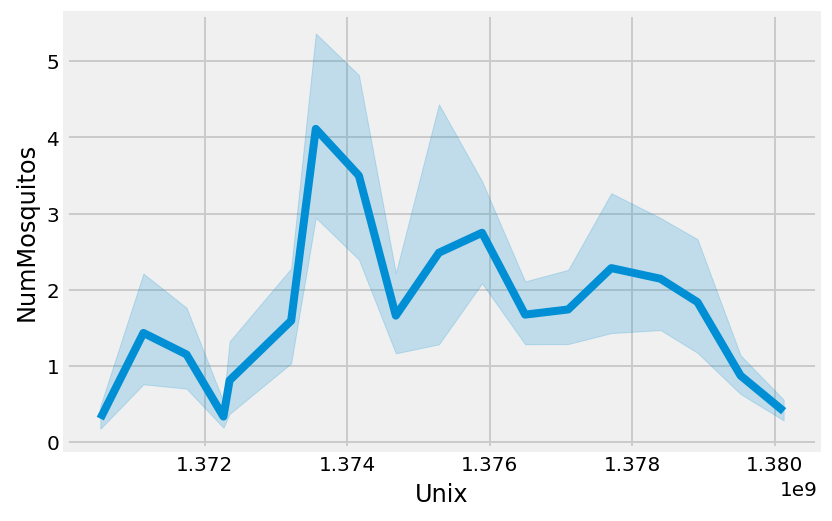

In [61]:
# Plot the distribution of mosquitoes vs the unix time

sns.lineplot(train_df_2013_unsprayed["Unix"], train_df_2013_unsprayed["NumMosquitos"])

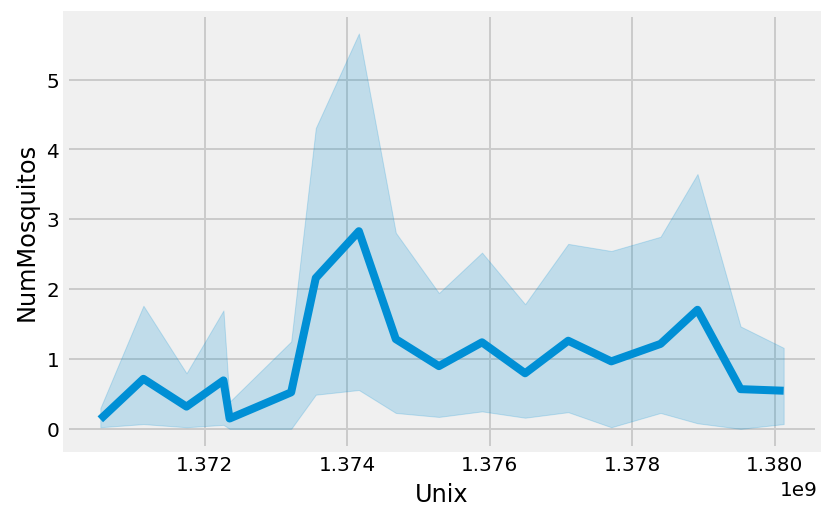

In [62]:
sns.lineplot(train_df_2013_sprayed["Unix"], train_df_2013_sprayed["NumMosquitos"])

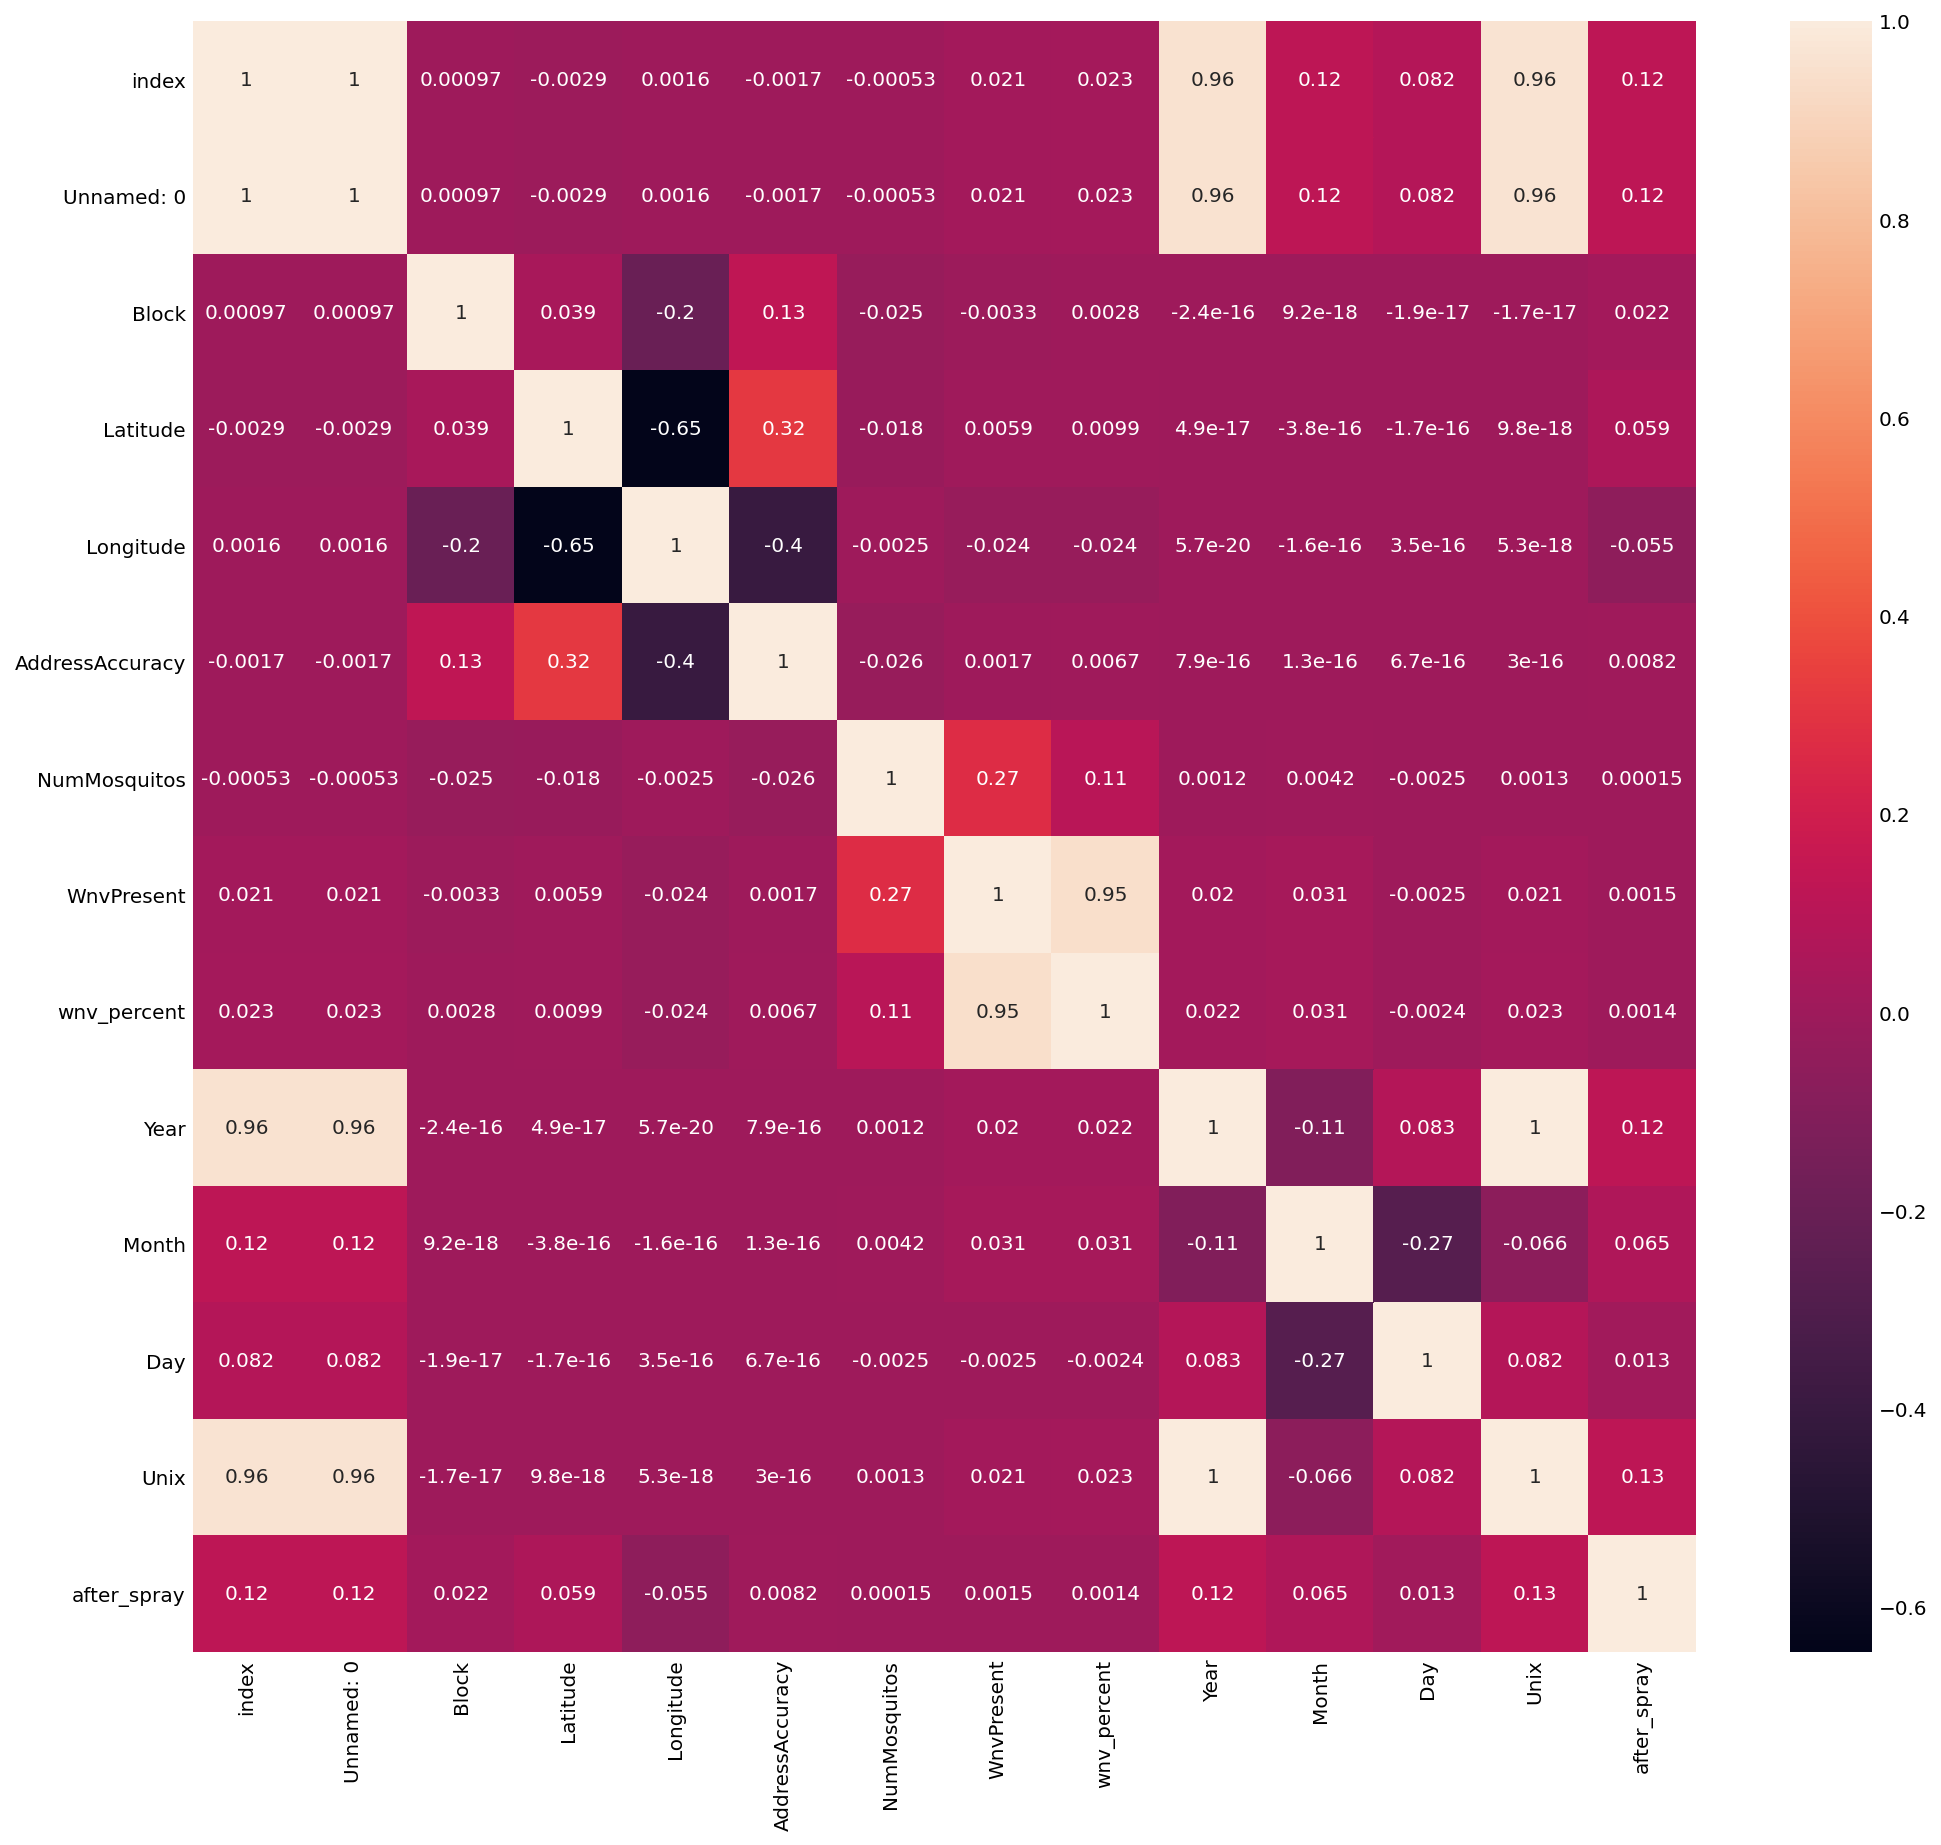

In [63]:
# There seems to be no strong correlation between variables 
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True)

### 6. Looking into Species of Mosquitos 

In [64]:
# Species 

df_train["Species"].value_counts()

CULEX TARSALIS            14345
CULEX RESTUANS            14345
CULEX PIPIENS             14345
CULEX TERRITANS           14345
UNSPECIFIED CULEX         14345
CULEX PIPIENS/RESTUANS    14345
CULEX SALINARIUS          14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

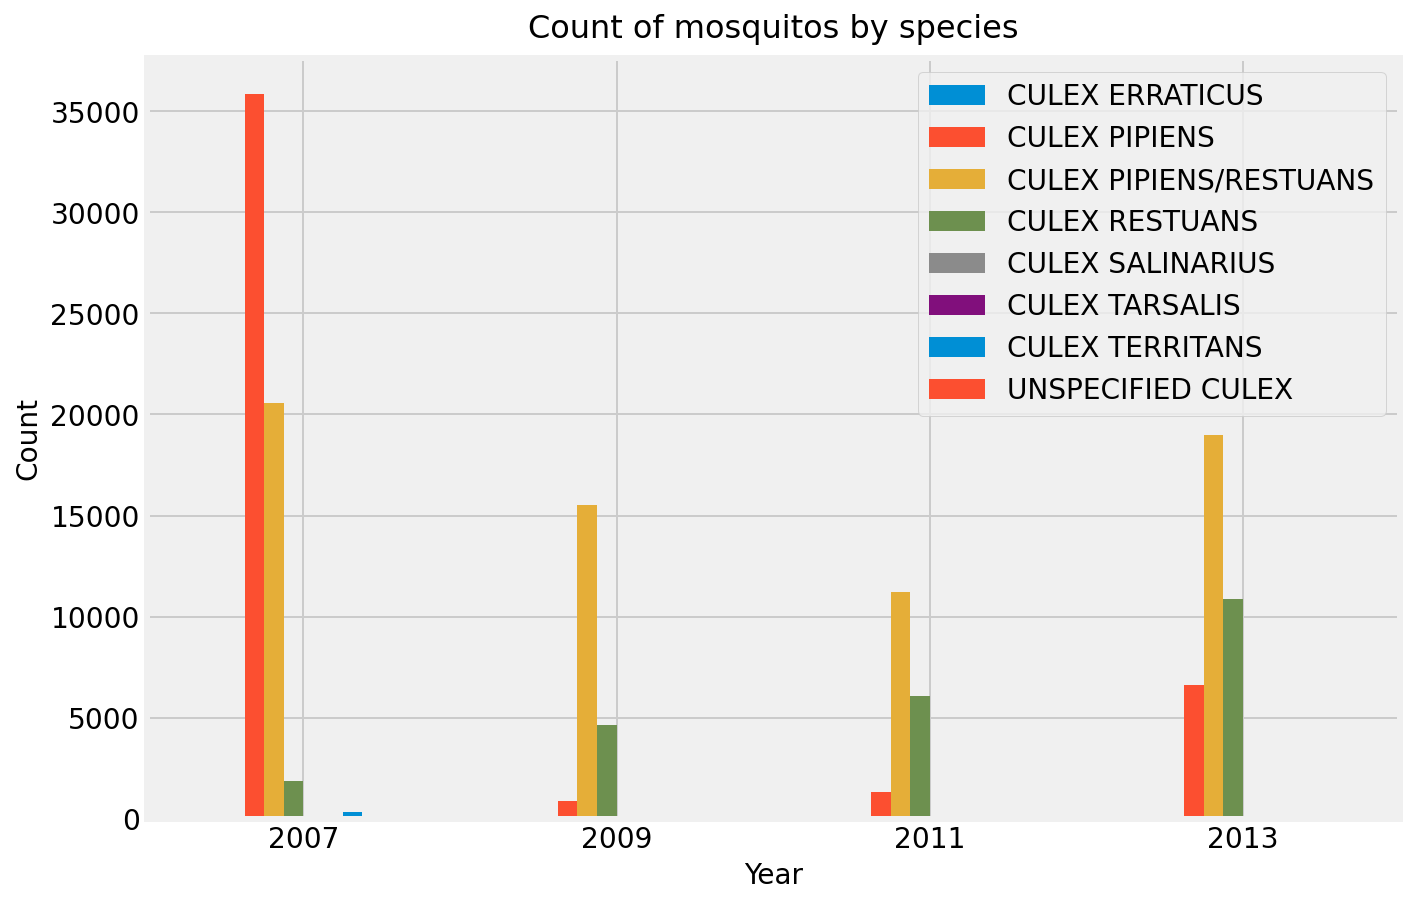

In [65]:
# Most common species of mosquitos caught are Culex Pipiens and Culex Restuans
# The probability of catching pipens and pipens/restuans were higher across all years
df_train.groupby(['Year','Species']).NumMosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by species', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

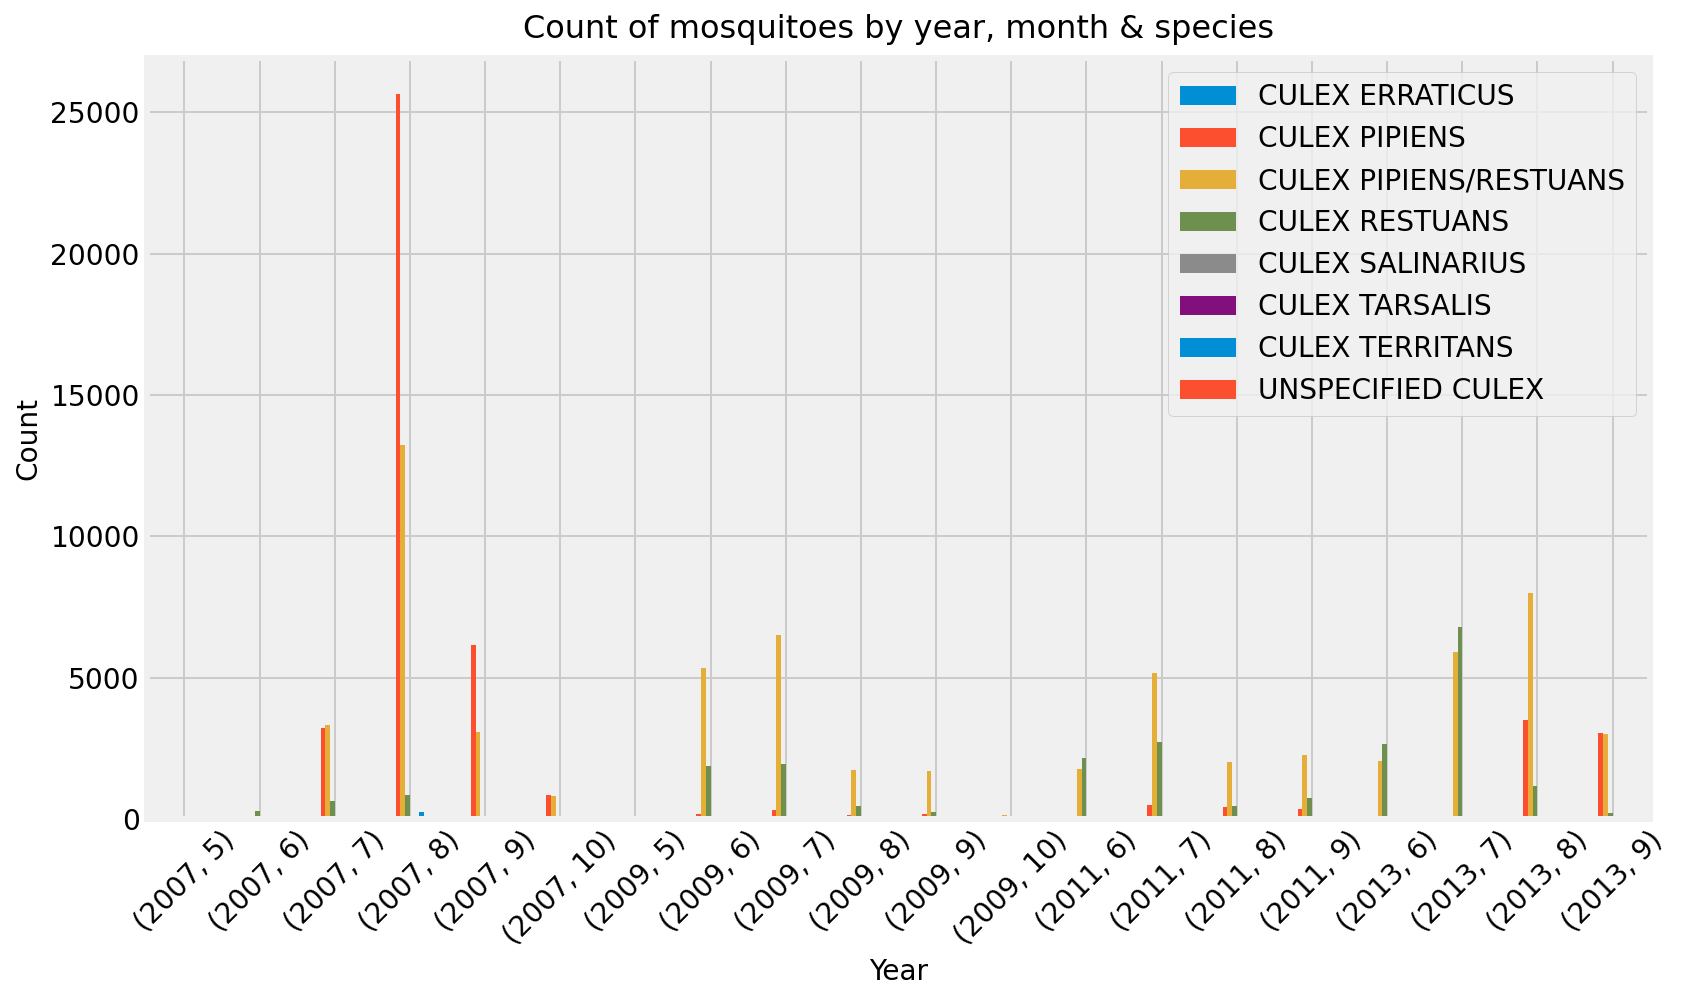

In [66]:
# Year Month and Species
df_train.groupby(['Year','Month', 'Species']).NumMosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(12,7))
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitoes by year, month & species', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

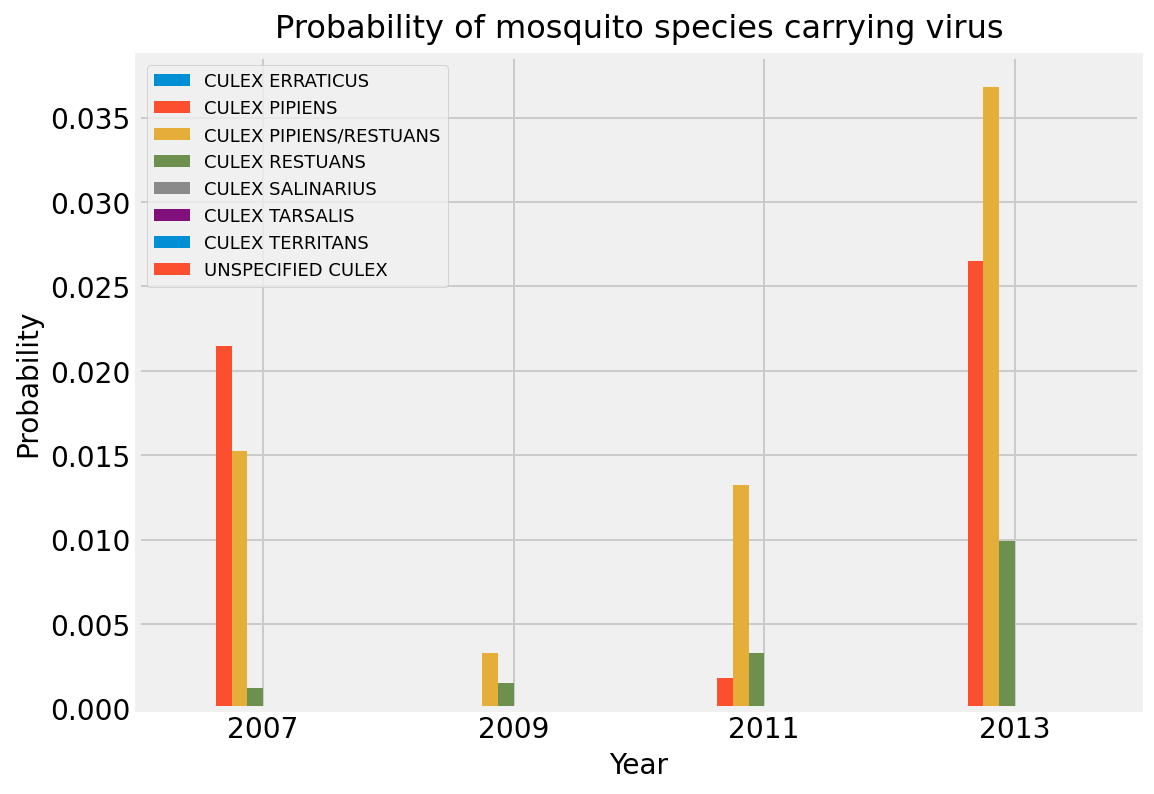

In [67]:
# Most common species of mosquitos caught are Culex Pipiens and Culex Pipiens/Restuans
# In 2007 Culex Pipen has the highest probability of carrying the virus
# In 2009, 2011 and 2013 culex pipens/restuans has the highest probabiltiy of carrying virus
df_train.groupby(['Year','Species']).WnvPresent.mean().unstack(fill_value=0).plot.bar(figsize=(8,6))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Probability of mosquito species carrying virus', fontsize=16, y=1.01)
plt.ylabel('Probability', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=9)
plt.show()

In [68]:
# One hot encode
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

species_onehot = ohe.fit_transform(df_train[["Species"]]).todense()

ohe.categories_

[array(['CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
        'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
        'CULEX TERRITANS', 'UNSPECIFIED CULEX'], dtype=object)]

In [69]:
species_onehot = pd.DataFrame(species_onehot, columns=ohe.categories_)

In [70]:
df_train = pd.concat([df_train, species_onehot], axis=1)
df_train.head(3)

,index,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,Unix,after_spray,"(CULEX ERRATICUS,)","(CULEX PIPIENS,)","(CULEX PIPIENS/RESTUANS,)","(CULEX RESTUANS,)","(CULEX SALINARIUS,)","(CULEX TARSALIS,)","(CULEX TERRITANS,)","(UNSPECIFIED CULEX,)"
0,0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,1.180368e+09,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,1.180368e+09,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,1.180368e+09,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


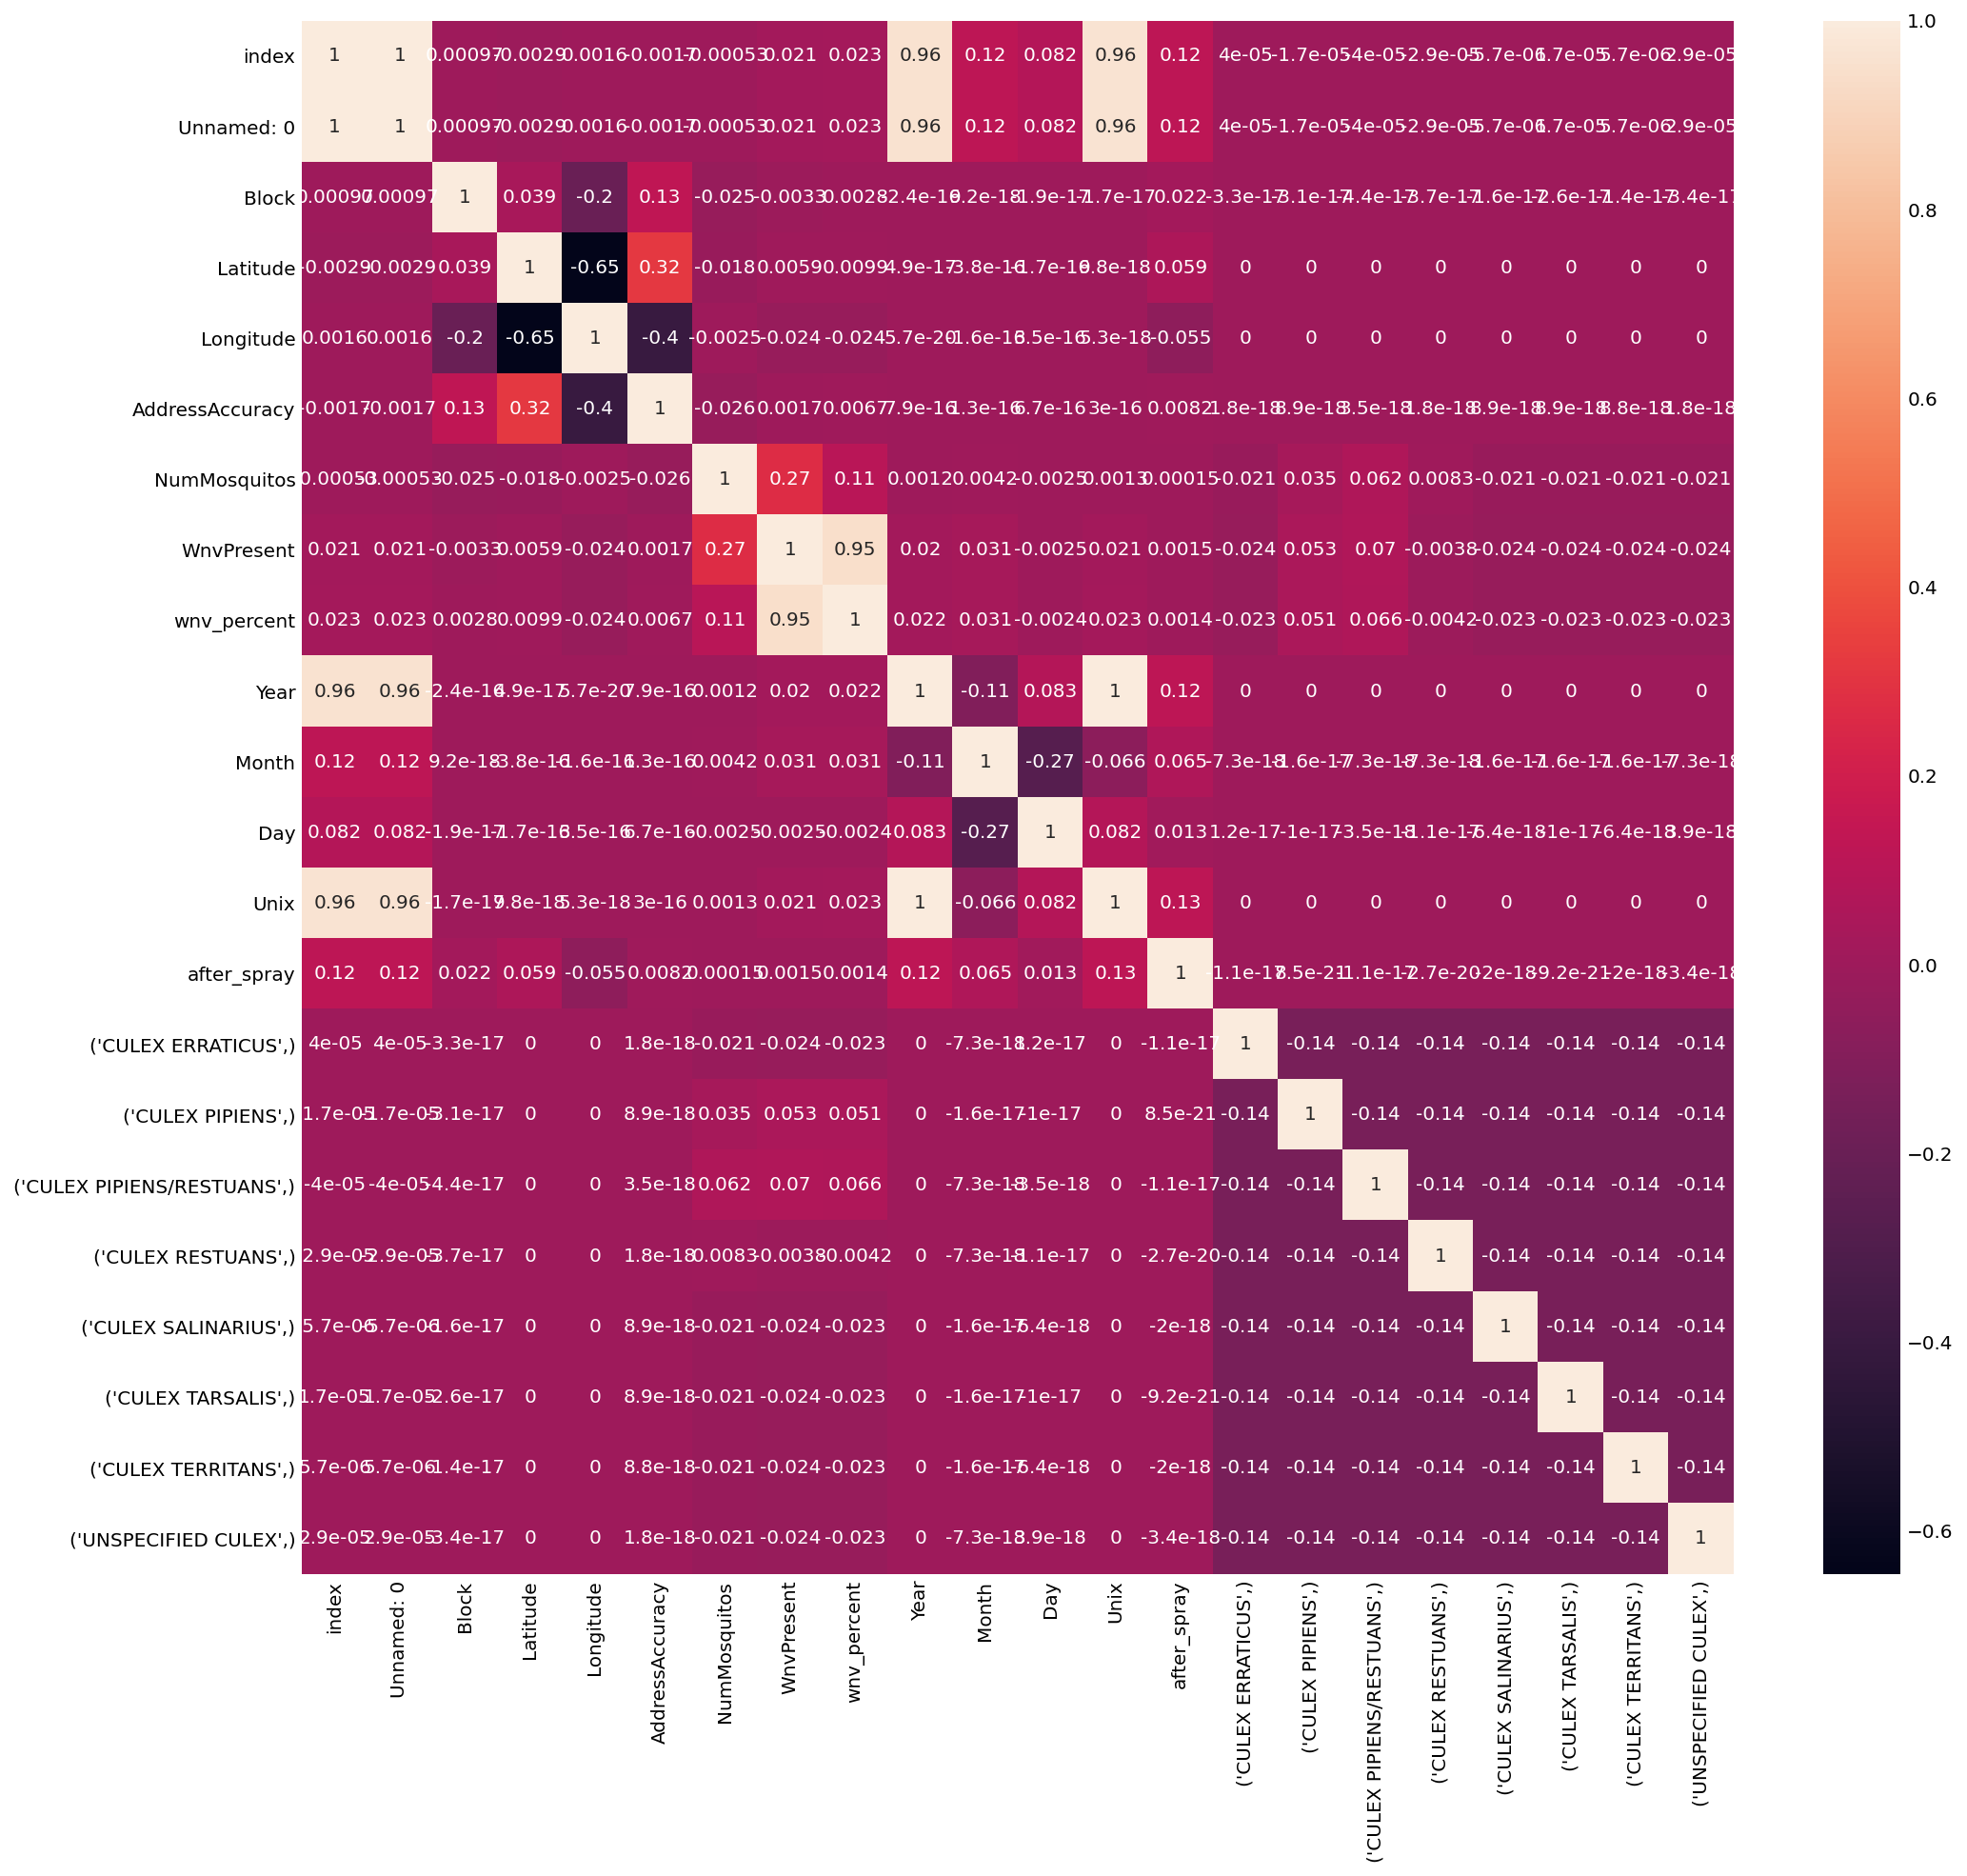

In [71]:
# Analyze the species. There seems to have no strong correlation among species
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True)

In [72]:
crs = {'init': 'epsg:4326'}

geometry_train = [Point(xy) for xy in zip(df_train['Longitude'], df_train['Latitude'])]

geo_df = gpd.GeoDataFrame(df_train,
                      crs=crs,
                      geometry=geometry_train)
geo_df.head()

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,index,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,after_spray,"(CULEX ERRATICUS,)","(CULEX PIPIENS,)","(CULEX PIPIENS/RESTUANS,)","(CULEX RESTUANS,)","(CULEX SALINARIUS,)","(CULEX TARSALIS,)","(CULEX TERRITANS,)","(UNSPECIFIED CULEX,)",geometry
0,0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT (-87.80099 41.95469)
1,1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,POINT (-87.80099 41.95469)
2,2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-87.80099 41.95469)
3,3,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POINT (-87.80099 41.95469)
4,4,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,POINT (-87.80099 41.95469)


In [73]:
street_map = gpd.read_file('../data/geo_export_d41dc94d-31ce-478c-902c-864695385885.shp')

In [74]:
# This is spray for all years 
geometry_spray = [Point(xy) for xy in zip(df_spray['Longitude'], df_spray['Latitude'])]

geo_spray_df = gpd.GeoDataFrame(df_spray,
                      crs=crs,
                      geometry=geometry_spray)
geo_spray_df.head()

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Date,Time,Latitude,Longitude,Year,Month,Day,Unix,geometry
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,1.314547e+09,POINT (-88.08916 42.39162)
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,1.314547e+09,POINT (-88.08916 42.39135)
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,1.314547e+09,POINT (-88.08916 42.39102)
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29,1.314547e+09,POINT (-88.08916 42.39064)
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29,1.314547e+09,POINT (-88.08886 42.39041)


In [75]:
df_station = pd.DataFrame({
    'station': ["O'HARE INTERNATIONAL AIRPORT", "MIDWAY INTL ARPT"],
    'latitude': [41.995, 41.786],
    'longitude': [-87.933, -87.752]
})

geometry_station = [Point(xy) for xy in zip(df_station['longitude'], df_station['latitude'])]

geo_station_df = gpd.GeoDataFrame(df_station,
                      crs=crs,
                      geometry=geometry_station)
geo_station_df.head()

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station,latitude,longitude,geometry
0,O'HARE INTERNATIONAL AIRPORT,41.995,-87.933,POINT (-87.93300 41.99500)
1,MIDWAY INTL ARPT,41.786,-87.752,POINT (-87.75200 41.78600)


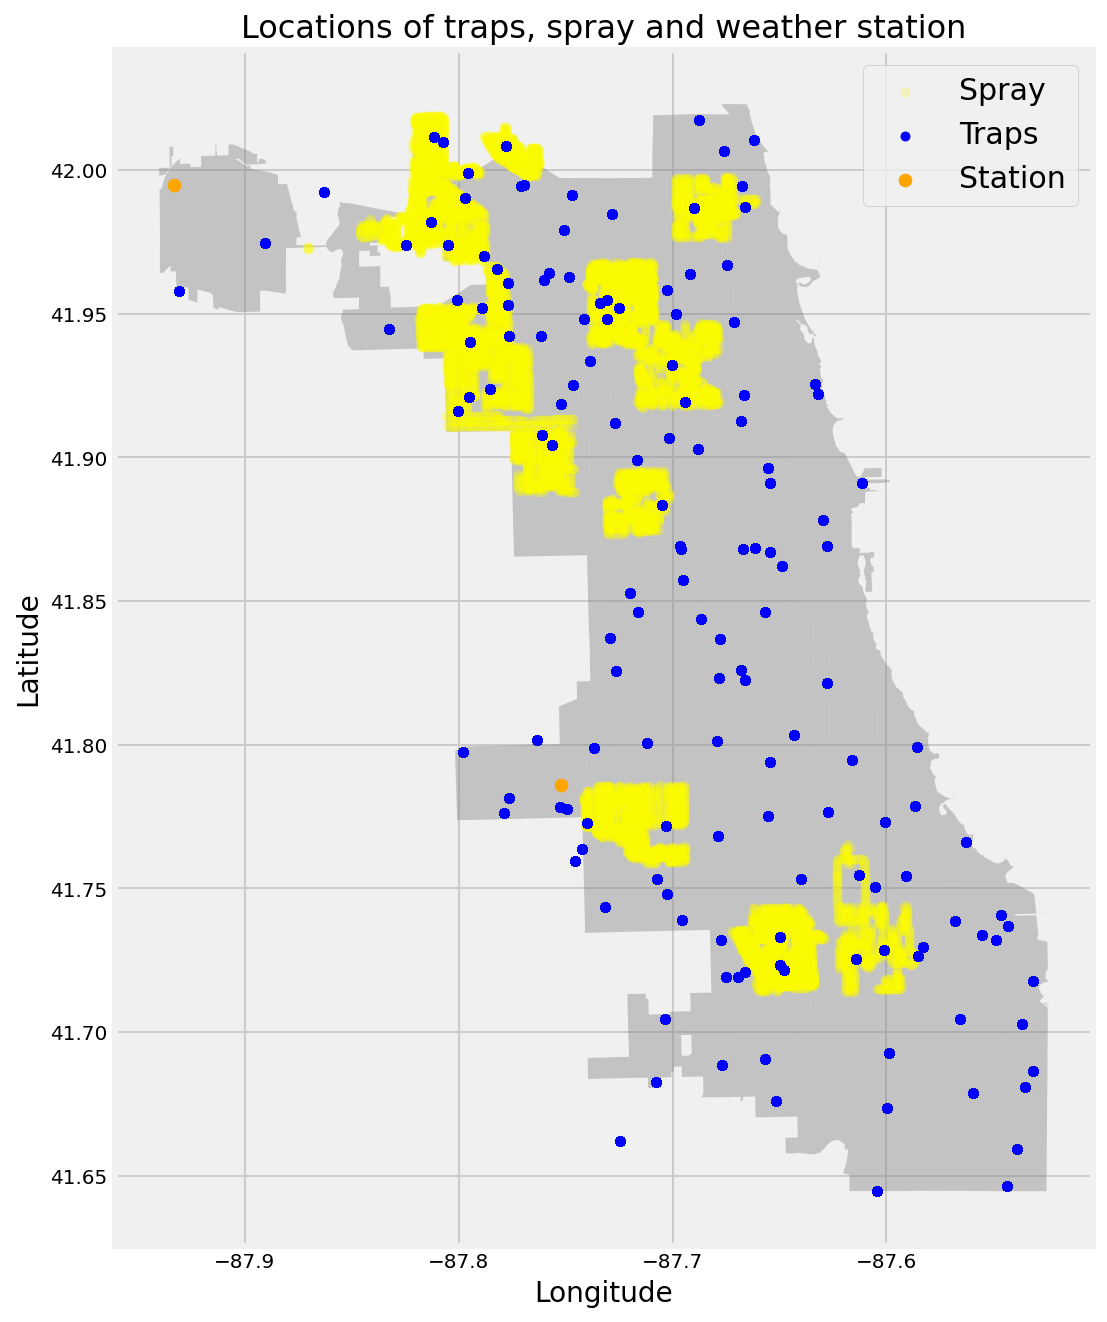

In [76]:
# Plot location of traps, spray and weather station
# There were spray locations outside Chicago and were filtered out from the plot

fig, ax = plt.subplots(figsize=(11,11))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_spray_df[geo_spray_df['Latitude']<42.3].plot(
    ax=ax, markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
geo_df.plot(ax=ax, markersize=20, color='blue', marker='o', label='Traps')
geo_station_df.plot(ax=ax, markersize=40, color='orange', marker='o', label='Station')
plt.legend(prop={'size': 15})
plt.title('Locations of traps, spray and weather station', fontsize=16, y=1.01)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

In [77]:
geometry = [Point(xy) for xy in zip(df_spray.Longitude, df_spray.Latitude)]

In [78]:
df_spray['geometry'] = geometry

In [79]:
df_spray.drop(['Latitude','Longitude'], axis = 1, inplace=True)

In [80]:
crs = {'init': 'epsg:4326'}
spray_locs = gpd.GeoDataFrame(df_spray, crs=crs, geometry=geometry)

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [81]:
spray_locs.head()

,Date,Time,Year,Month,Day,Unix,geometry
0,2011-08-29,6:56:58 PM,2011,8,29,1.314547e+09,POINT (-88.08916 42.39162)
1,2011-08-29,6:57:08 PM,2011,8,29,1.314547e+09,POINT (-88.08916 42.39135)
2,2011-08-29,6:57:18 PM,2011,8,29,1.314547e+09,POINT (-88.08916 42.39102)
3,2011-08-29,6:57:28 PM,2011,8,29,1.314547e+09,POINT (-88.08916 42.39064)
4,2011-08-29,6:57:38 PM,2011,8,29,1.314547e+09,POINT (-88.08886 42.39041)


In [82]:
city_bound = gpd.read_file("../data/geo_export_55fcb48c-7621-4c8a-999c-9fb3c86e8950.shp")

In [83]:
train_geo = [Point(xy) for xy in zip(df_train['Longitude'], df_train['Latitude'])]

In [84]:
df_train['location'] = train_geo

In [85]:
df_train.drop(['Latitude','Longitude'], axis=1, inplace=True)

In [86]:
mosquito_locs = gpd.GeoDataFrame(df_train, crs=crs, geometry=train_geo)

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [87]:
street_map = gpd.read_file('../data/geo_export_d41dc94d-31ce-478c-902c-864695385885.shp')

In [88]:
def location_check(list_of_points, boundary):
    in_boundary = []
    counter = 0
    for i in list_of_points:
        while counter < len(list_of_points):
            if boundary.contains(list_of_points[counter])[0]:
                in_boundary.append(1)
            else:
                in_boundary.append(0)
            counter += 1
    return in_boundary

In [89]:
mosq_incity = location_check(mosquito_locs.location, city_bound)

In [90]:
spray_incity = location_check(geo_spray_df.geometry, city_bound)

In [91]:
mosquito_locs['mosq_incity'] = mosq_incity

In [92]:
mosquito_locs = mosquito_locs[mosquito_locs['mosq_incity'] == 1]

In [93]:
spray_locs.shape

(14835, 7)

In [94]:
spray_locs['spray_incity'] = spray_incity

In [95]:
spray_locs = spray_locs[spray_locs['spray_incity'] == 1]

In [96]:
spray_locs.shape

(14666, 8)

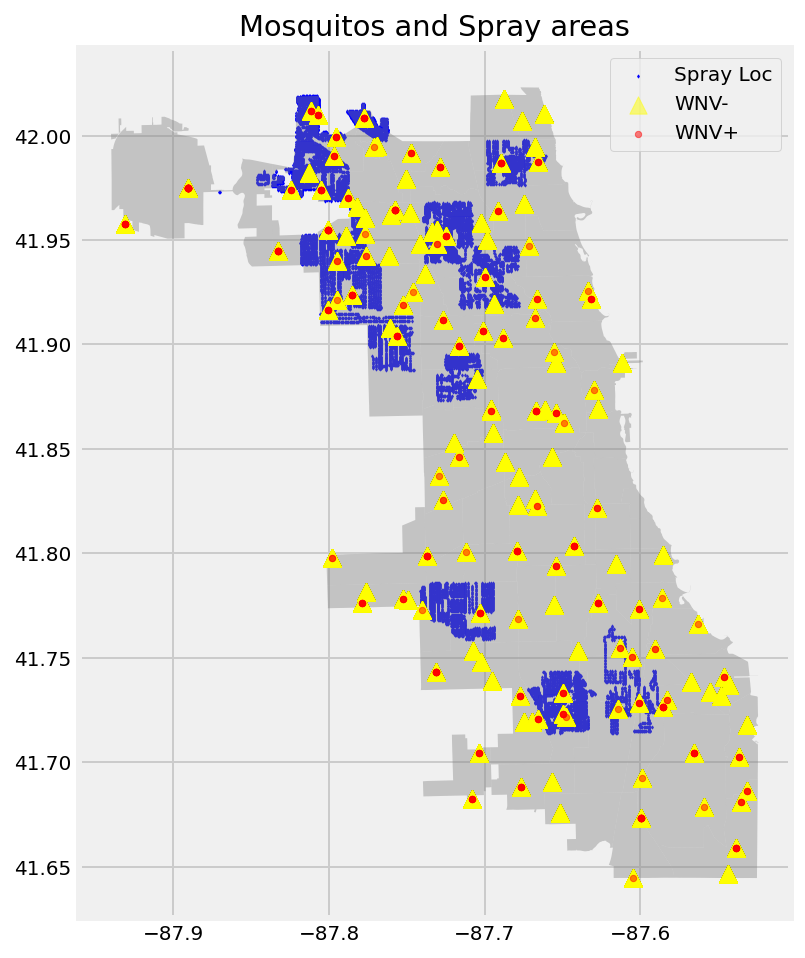

In [97]:
fig, ax = plt.subplots(figsize = (8,8))
spray_locs.geometry.plot(marker='d', color='blue', markersize=1, ax=ax, label = 'Spray Loc')
street_map.plot(color='grey', ax=ax, alpha = 0.4)
mosquito_locs[mosquito_locs['WnvPresent']==0].geometry.plot(marker='^', color = 'yellow', ax = ax, label = 'WNV-', alpha=.5, markersize = 75 )
mosquito_locs[mosquito_locs['WnvPresent']==1].geometry.plot(marker='o', color = 'red', ax = ax, label = 'WNV+', alpha = .5, markersize = 10)
# at first glance, it looks as though WNV- mosquitos were found alongside WNV+ mosquitos everytime a WNV+ mosquito was found
    #however, there are lots of instances where WNV- mosquitos were found with WNV+ mosquitos


plt.title('Mosquitos and Spray areas')
plt.legend()

### 7. Looking into Time

In [98]:
# no. of observations by month
df_train["Month"].value_counts()

8     31408
9     26576
7     25368
6     25368
10     3624
5      2416
Name: Month, dtype: int64

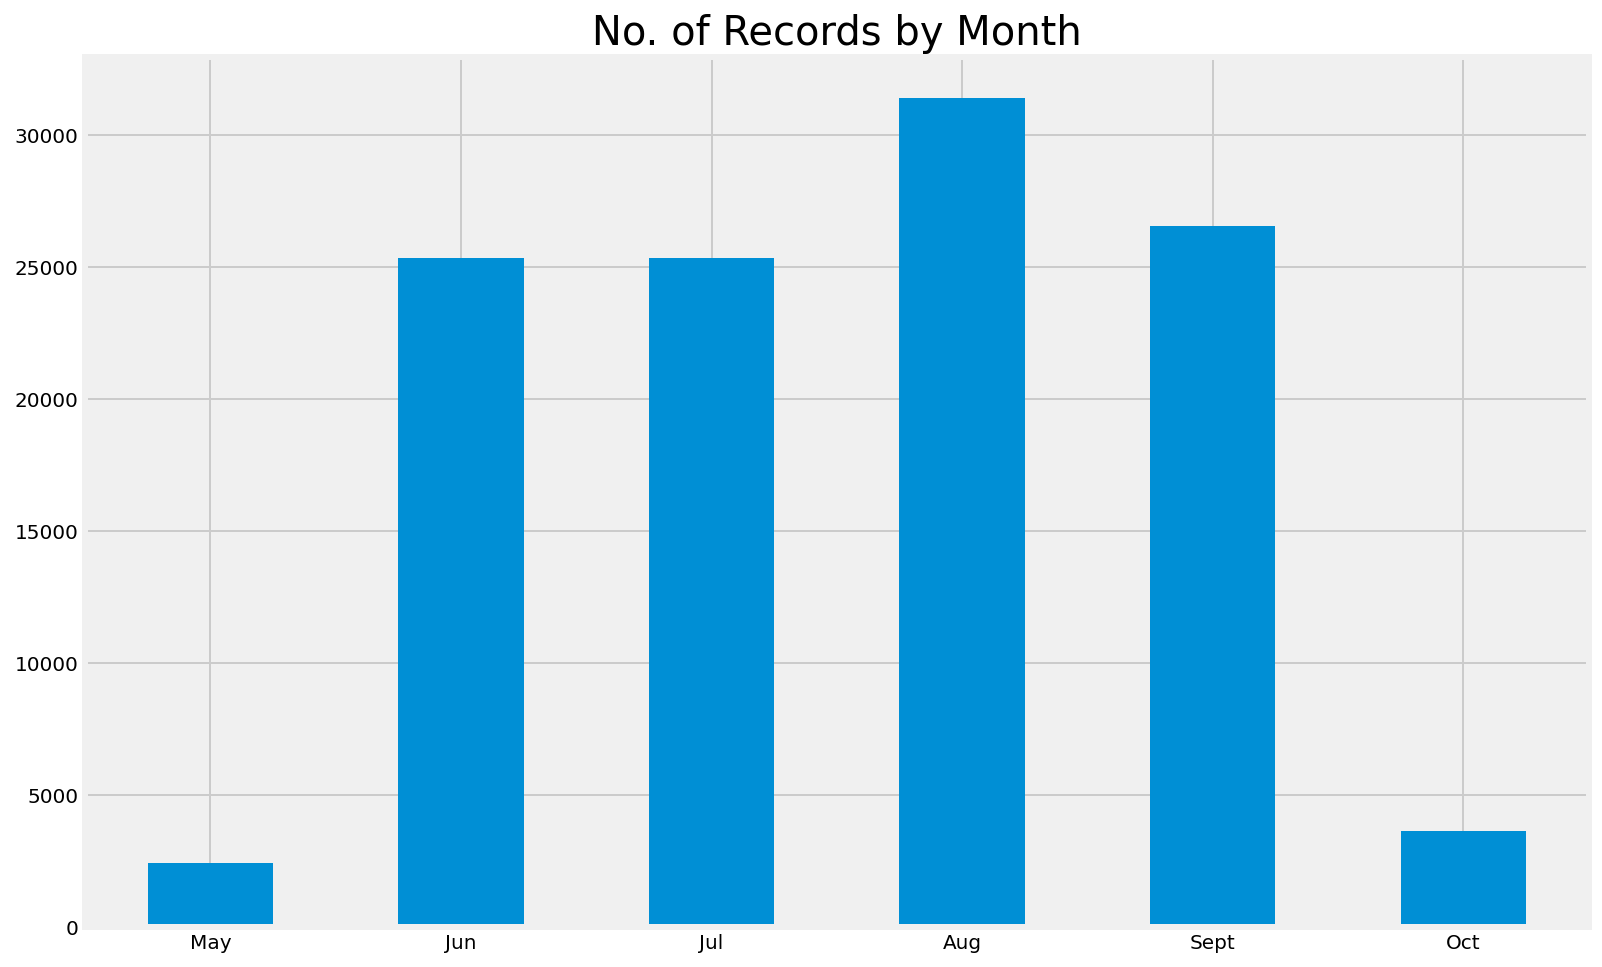

In [99]:
# Most of the records are coming from between Jun to September
fig, ax = plt.subplots(figsize=[12,8])

plt.title("No. of Records by Month", size=20)

month_order = np.arange(5,11,1) # set out order of months to plot
ax = df_train["Month"].value_counts().loc[month_order].plot(kind="bar")

ax.set_xticklabels(["May", "Jun", "Jul", "Aug", "Sept", "Oct"], rotation=0)

plt.show()

In [100]:
# no. of observations by year
df_train["Year"].value_counts()

2007    39864
2009    31408
2013    21744
2011    21744
Name: Year, dtype: int64

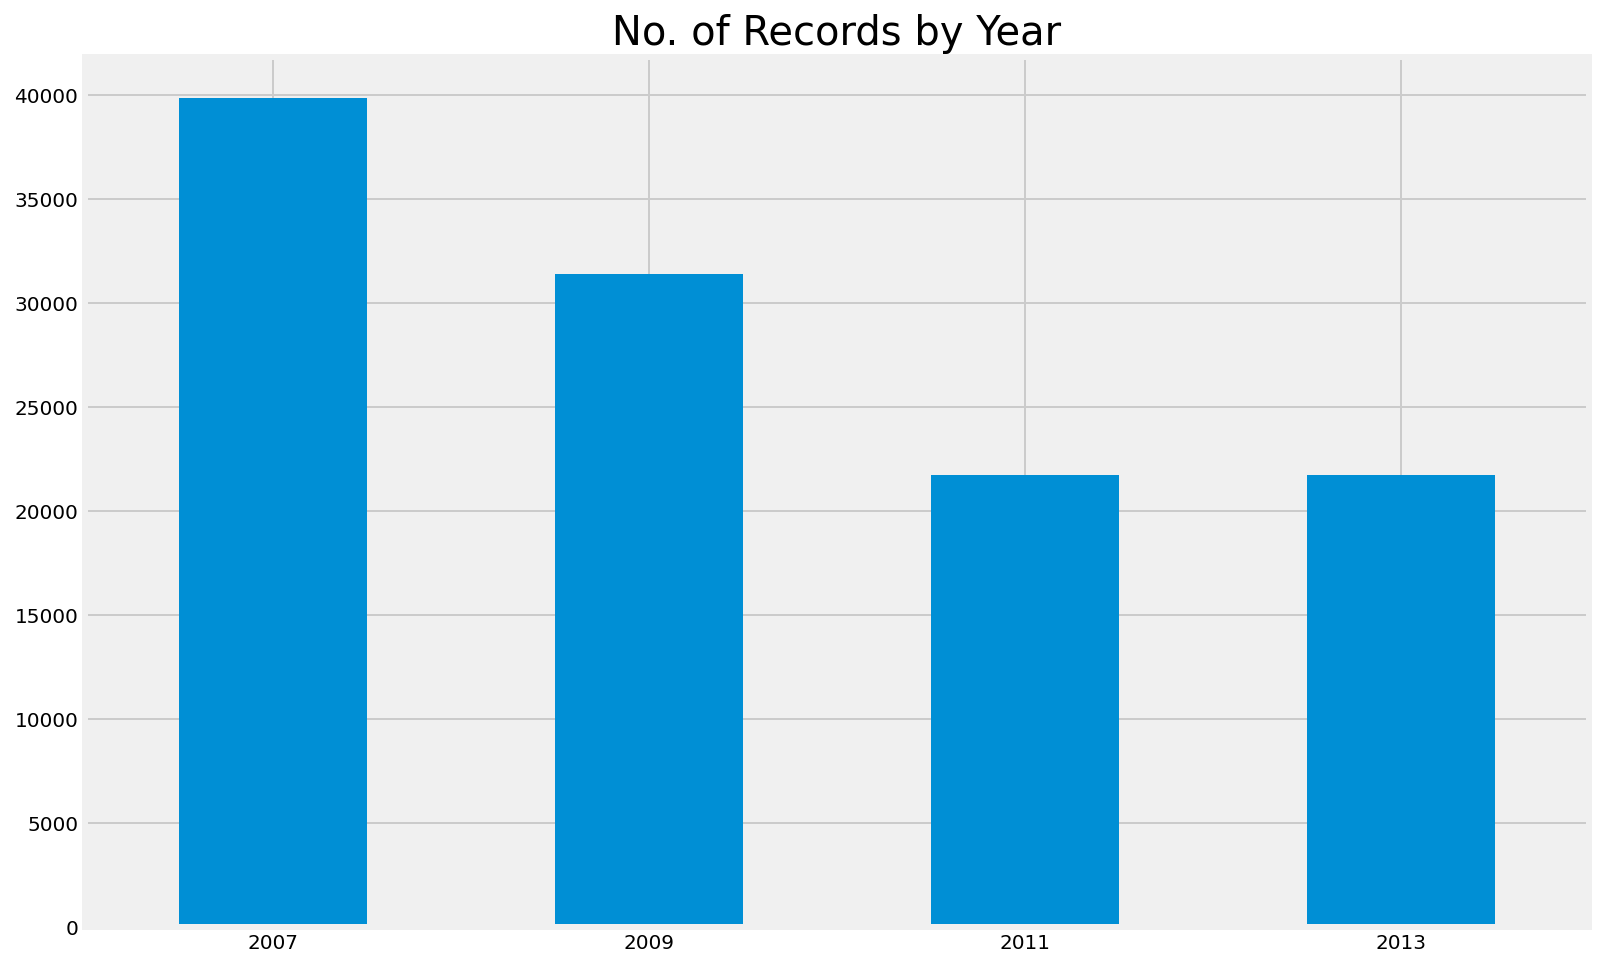

In [101]:
# Most of the records come from year 2007 and 2009 (before spray)
fig, ax = plt.subplots(figsize=[12,8])

plt.title("No. of Records by Year", size=20)

year_order = [2007, 2009, 2011, 2013] # set out order of years to plot
ax = df_train["Year"].value_counts().loc[year_order].plot(kind="bar")

plt.xticks(rotation=0)

plt.show()

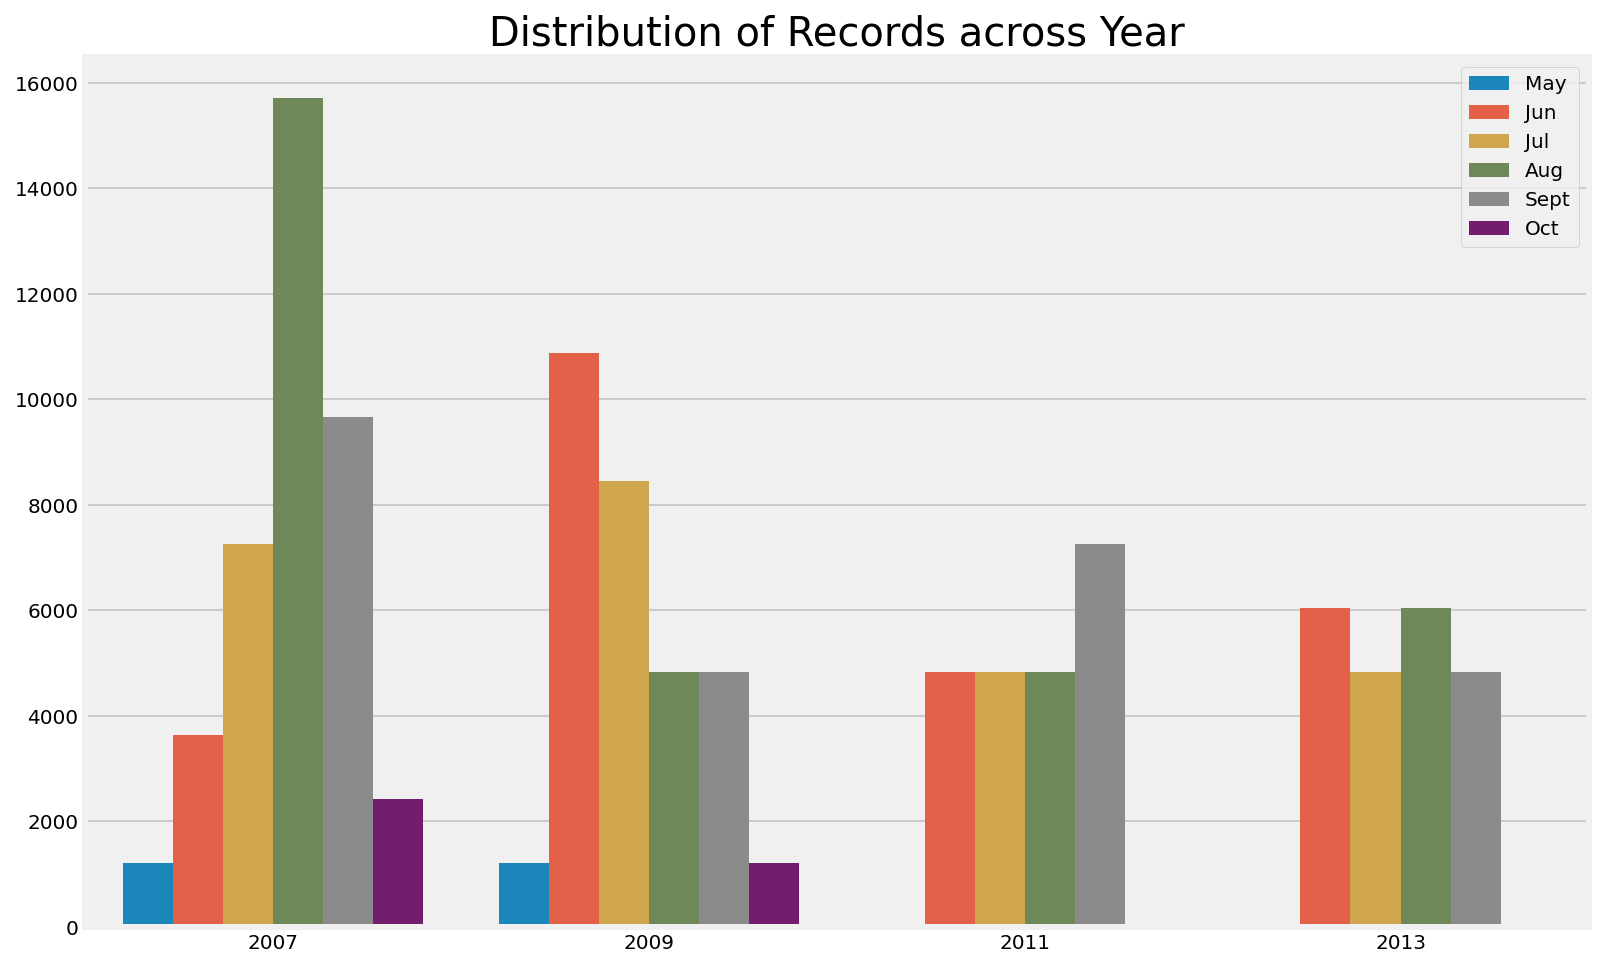

In [102]:
# August and June were the months where most records come from in 2007 and 2009 respectively
# Most records come from September in 2011
# All months are equal in 2013
plt.figure(figsize=[12,8])

sns.countplot(data=df_train, x="Year", hue="Month")

plt.title("Distribution of Records across Year", size=20)
plt.xlabel("") # no need for labels
plt.ylabel("") # no need for labels
plt.legend(["May", "Jun", "Jul", "Aug", "Sept", "Oct"], loc=1)

plt.show()

In [103]:
df_train.groupby("Year").get_group(2011)["Month"].value_counts()

9    7248
8    4832
7    4832
6    4832
Name: Month, dtype: int64

In [104]:
df_train.groupby("Year").get_group(2013)["Month"].value_counts()

8    6040
6    6040
9    4832
7    4832
Name: Month, dtype: int64

In [105]:
years = df_train.groupby("Year")
df_train_2007 = years.get_group(2007)
df_train_2009 = years.get_group(2009)
df_train_2011 = years.get_group(2011)
df_train_2013 = years.get_group(2013)

In [106]:
freq_to_plot = [] # create empty list
# find no. of unique observation dates per Month
freq_to_plot.append(dict(df_train_2007.groupby("Month")["Date"].nunique()))
freq_to_plot.append(dict(df_train_2009.groupby("Month")["Date"].nunique()))
freq_to_plot.append(dict(df_train_2011.groupby("Month")["Date"].nunique()))
freq_to_plot.append(dict(df_train_2013.groupby("Month")["Date"].nunique()))
freq_to_plot

[{5: 1, 6: 3, 7: 6, 8: 13, 9: 8, 10: 2},
 {5: 1, 6: 9, 7: 7, 8: 4, 9: 4, 10: 1},
 {6: 4, 7: 4, 8: 4, 9: 6},
 {6: 5, 7: 4, 8: 5, 9: 4}]

In [107]:
df_plot_freq = pd.DataFrame(freq_to_plot, index=[2007, 2009, 2011, 2013])
df_plot_freq

,5,6,7,8,9,10
2007,1.0,3,6,13,8,2.0
2009,1.0,9,7,4,4,1.0
2011,NaN,4,4,4,6,NaN
2013,NaN,5,4,5,4,NaN


## 8. Looking into Trap

In [108]:
df_train.groupby("Year")["Trap"].nunique()

Year
2007    151
2009    151
2011    151
2013    151
Name: Trap, dtype: int64

In [109]:
traps_to_plot = [] # create empty list
# find no. of unique traps laid/collected per Month
traps_to_plot.append(dict(df_train_2007.groupby("Month")["Trap"].nunique()))
traps_to_plot.append(dict(df_train_2009.groupby("Month")["Trap"].nunique()))
traps_to_plot.append(dict(df_train_2011.groupby("Month")["Trap"].nunique()))
traps_to_plot.append(dict(df_train_2013.groupby("Month")["Trap"].nunique()))
traps_to_plot

[{5: 151, 6: 151, 7: 151, 8: 151, 9: 151, 10: 151},
 {5: 151, 6: 151, 7: 151, 8: 151, 9: 151, 10: 151},
 {6: 151, 7: 151, 8: 151, 9: 151},
 {6: 151, 7: 151, 8: 151, 9: 151}]

In [110]:
df_trap_freq = pd.DataFrame(traps_to_plot, index=[2007, 2009, 2011, 2013])
df_trap_freq

,5,6,7,8,9,10
2007,151.0,151,151,151,151,151.0
2009,151.0,151,151,151,151,151.0
2011,NaN,151,151,151,151,NaN
2013,NaN,151,151,151,151,NaN


In [111]:
df_train.groupby("Month")["NumMosquitos"].sum()

Month
5       230
6     16578
7     37248
8     58036
9     21029
10     1918
Name: NumMosquitos, dtype: int64

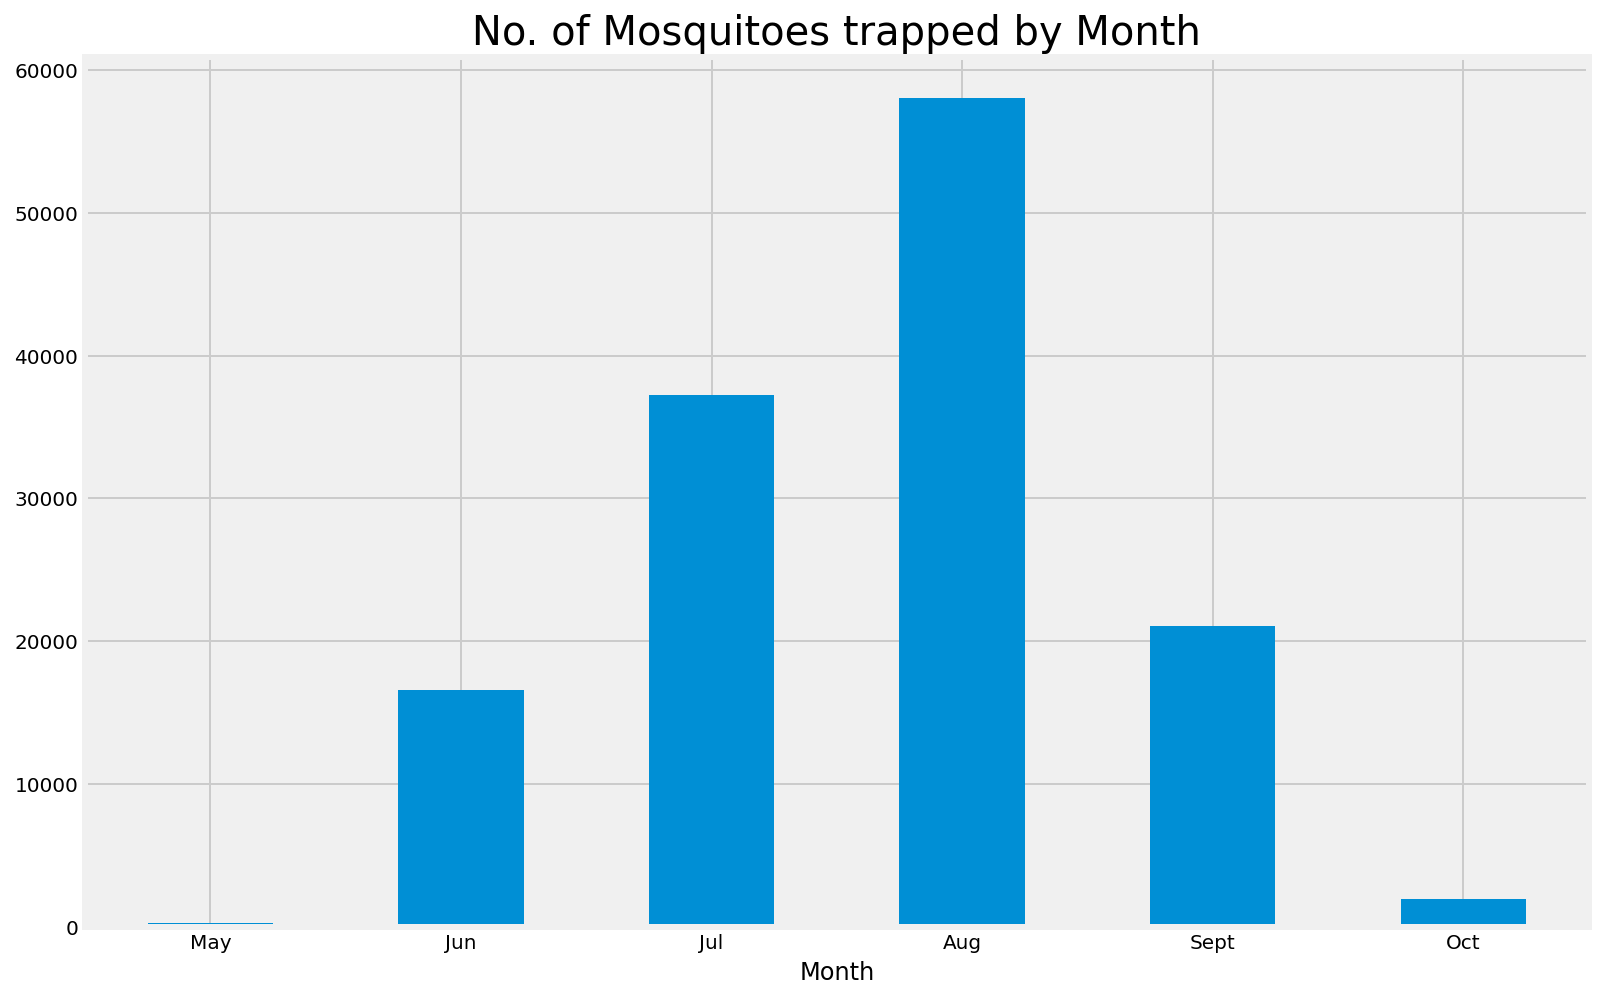

In [112]:
# Most number of mosquitoes trapped were in August
# August would has the highest probability of successfully trapping mosquitoes 
fig, ax = plt.subplots(figsize=[12,8])

plt.title("No. of Mosquitoes trapped by Month", size=20)

ax = df_train.groupby("Month")["NumMosquitos"].sum().plot(kind="bar")

ax.set_xticklabels(["May", "Jun", "Jul", "Aug", "Sept", "Oct"], rotation=0)

plt.show()

In [113]:
df_train.groupby("Year")["NumMosquitos"].sum()

Year
2007    58688
2009    21108
2011    18799
2013    36444
Name: NumMosquitos, dtype: int64

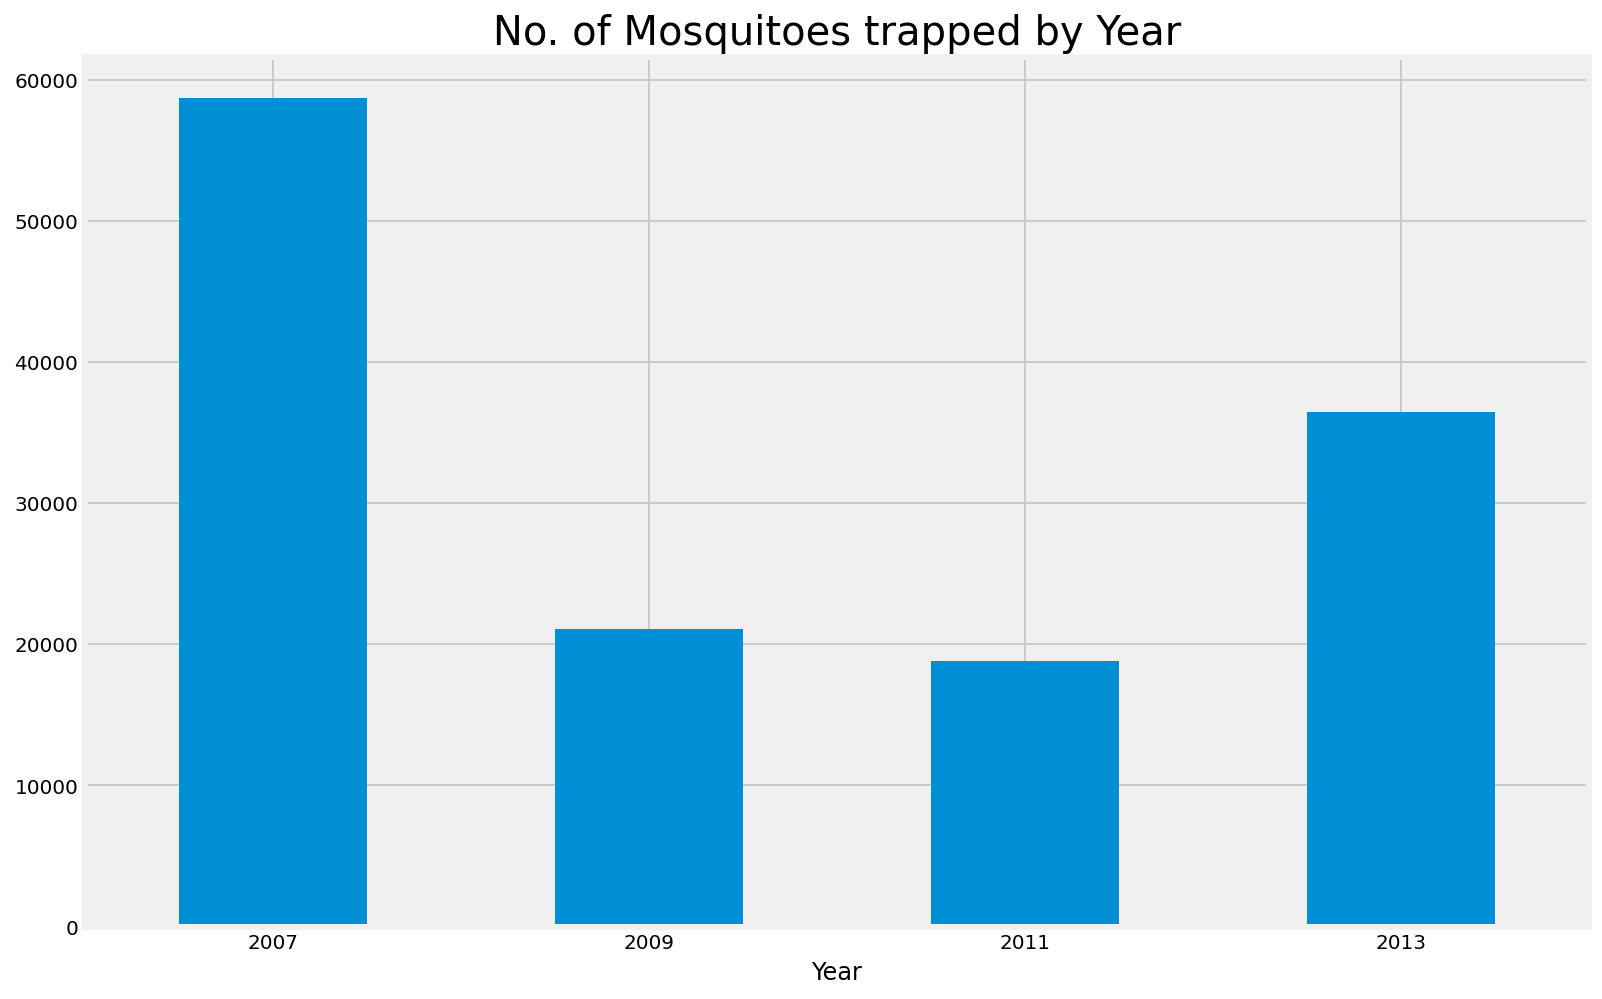

In [114]:
# 2007 trapped the most number of mosquitoes
# Probability of successfully trapping mosquitoes would be highest in 2007 
fig, ax = plt.subplots(figsize=[12,8])

plt.title("No. of Mosquitoes trapped by Year", size=20)

ax = df_train.groupby("Year")["NumMosquitos"].sum().plot(kind="bar")

plt.xticks(rotation=0)

plt.show()

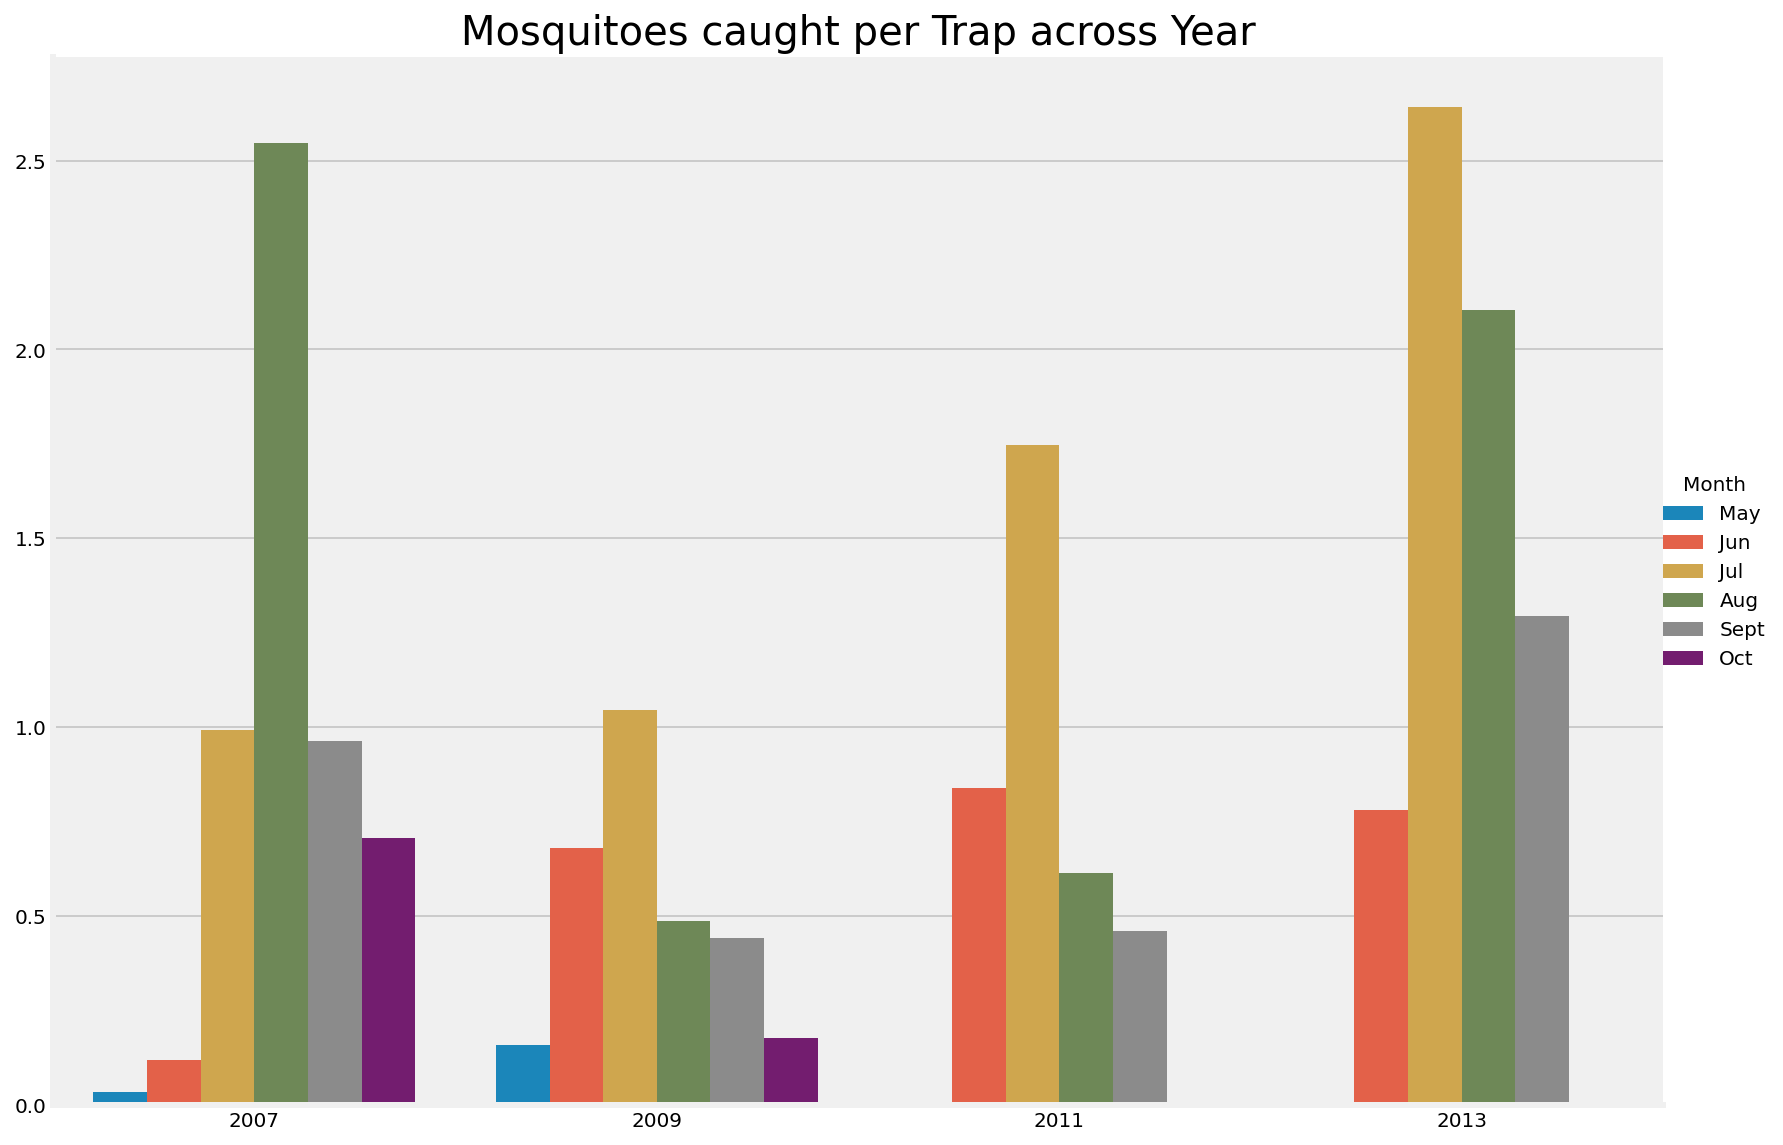

In [115]:
# Most number of mosquitoes trapped in August 2007
# Most number of mosquitoes trapped in July for all three years 2009, 2011, 2013
# This means that the probability of trapping mosquitoes were highest in July for 2009, 2011, 2013
# The highest probability of successfully trapping a mosquito was in August for year 2007
g = sns.catplot(kind="bar", data=df_train, x="Year", hue="Month", y="NumMosquitos", ci=False,
                height=8, aspect=1.5, legend_out=True)

plt.title("Mosquitoes caught per Trap across Year", size=20)
plt.xlabel("") # no need for labels
plt.ylabel("") # no need for labels
legend = g._legend
for t, l in zip(legend.texts,["May", "Jun", "Jul", "Aug", "Sept", "Oct"]):
    t.set_text(l)

plt.show()

## 9. Weather

In [116]:
df_weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [117]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [118]:
df_weather.nunique()
# weather information from 2 relevant stations only
# from Kaggle:
### Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
### Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

Station           2
Date           1472
Tmax             63
Tmin             54
Tavg             60
Depart           42
DewPoint         54
WetBulb          48
Heat             31
Cool             31
Sunrise         122
Sunset          119
CodeSum          98
Depth             2
Water1            1
SnowFall          4
PrecipTotal     168
StnPressure     104
SeaLevel        102
ResultSpeed     190
ResultDir        36
AvgSpeed        178
dtype: int64

In [119]:
# convert "Date" from str to datetime obj
df_weather["Date"] = pd.to_datetime(df_weather["Date"])
df_weather.info() # verify formatting is updated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [120]:
df_weather["Tavg"].unique() # average temp
# M stands for missing value

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [121]:
df_weather["Depart"].unique() # departure from normal (temp?)
# M stands for missing value

array(['14', 'M', '-3', ' 2', ' 4', ' 5', '10', '12', '13', '-2', '15',
       '11', '-4', '-6', ' 8', '-5', ' 1', ' 9', ' 6', '-9', '-8', ' 3',
       ' 0', '-1', '-7', ' 7', '-14', '18', '16', '22', '21', '20', '-10',
       '-16', '17', '-12', '-11', '-15', '-17', '19', '-13', '23'],
      dtype=object)

In [122]:
df_weather["WetBulb"].unique() # wetbulb temp - coolest temp possibly achieved at given time assuming 100% humidity
# M stands for missing value

array(['56', '57', '47', '48', '50', '49', '46', '54', '53', '62', '63',
       '60', '61', '51', '59', '58', '43', '44', '45', '65', '66', '67',
       '64', '52', '55', '69', '68', '70', '72', '71', '73', '74', '76',
       '42', '39', '40', '41', '35', '33', '34', 'M', '75', '36', '32',
       '38', '78', '77', '37'], dtype=object)

In [123]:
df_weather["DewPoint"].describe()
# dewpoint temp - temp to which air must be cooled for condesation to happen
# dependant on both humidity levels and temperature (and possibly other factors, wind?)

count    2944.000000
mean       53.457880
std        10.675181
min        22.000000
25%        46.000000
50%        54.000000
75%        62.000000
max        75.000000
Name: DewPoint, dtype: float64

In [124]:
def replace_m_null(df, col):
    df[col] = df[col].str.replace("M", "99999") # use placeholder numeric value
    df[col] = df[col].astype(float) # convert to float objs
    null_val = df[col] == 99999 # create mask to find placeholders
    df.loc[null_val, col] = np.nan # replace placeholders with true nulls

In [125]:
replace_m_null(df=df_weather, col="Tavg") # replace "M" with null values

In [126]:
replace_m_null(df=df_weather, col="Depart") # replace "M" with null values

In [127]:
replace_m_null(df=df_weather, col="WetBulb") # replace "M" with null values

In [128]:
df_weather.info() # verify change has been made

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   float64       
 5   Depart       1472 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   float64       
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [129]:
missing = df_weather["Tavg"].isnull()
df_weather[missing][["Tmax", "Tmin", "Tavg"]] # view missing average temperatures

,Tmax,Tmin,Tavg
7,78,51,NaN
505,86,46,NaN
675,62,46,NaN
1637,100,71,NaN
2067,84,72,NaN
2211,71,42,NaN
2501,91,52,NaN
2511,84,53,NaN
2525,76,48,NaN
2579,80,47,NaN


In [130]:
round(((df_weather["Tmax"] - df_weather["Tmin"])/2) + df_weather["Tmin"], 0)

0       66.0
1       68.0
2       50.0
3       52.0
4       56.0
        ... 
2939    44.0
2940    42.0
2941    45.0
2942    40.0
2943    42.0
Length: 2944, dtype: float64

In [131]:
# average temp should not be missing if we have both max and min temp
# impute missing average temp values
df_weather.loc[missing, "Tavg"] = round(((df_weather["Tmax"] - df_weather["Tmin"])/2) + df_weather["Tmin"], 0)

In [132]:
df_weather["Tavg"] = df_weather["Tavg"].astype(int) # convert to int

In [133]:
df_weather[missing][["Tmax", "Tmin", "Tavg"]] # verify imputation

,Tmax,Tmin,Tavg
7,78,51,64
505,86,46,66
675,62,46,54
1637,100,71,86
2067,84,72,78
2211,71,42,56
2501,91,52,72
2511,84,53,68
2525,76,48,62
2579,80,47,64


In [134]:
df_weather["Heat"].unique()
# M stands for missing value

array(['0', '14', '13', '9', '7', 'M', '5', '6', '4', '10', '8', '12',
       '3', '2', '1', '15', '16', '19', '17', '20', '11', '18', '21',
       '25', '24', '27', '26', '23', '28', '22', '29'], dtype=object)

In [135]:
df_weather["Cool"].unique()
# M stands for missing value

array([' 2', ' 3', ' 0', 'M', ' 5', ' 4', ' 6', ' 8', ' 7', ' 9', '10',
       '13', '11', '12', ' 1', '15', '16', '17', '14', '20', '19', '18',
       '21', '22', '24', '27', '23', '26', '28', '29', '25'], dtype=object)

In [136]:
replace_m_null(df=df_weather, col="Heat") # replace "M" with null values

In [137]:
replace_m_null(df=df_weather, col="Cool") # replace "M" with null values

In [138]:
df_weather.info() # verify change has been made

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       1472 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   float64       
 8   Heat         2933 non-null   float64       
 9   Cool         2933 non-null   float64       
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [139]:
df_weather[["Station", "Date", "Sunrise", "Sunset"]]
# notice sunrise and sunset times not repeated for each day between stations

,Station,Date,Sunrise,Sunset
0,1,2007-05-01,0448,1849
1,2,2007-05-01,-,-
2,1,2007-05-02,0447,1850
3,2,2007-05-02,-,-
4,1,2007-05-03,0446,1851
...,...,...,...,...
2939,2,2014-10-29,-,-
2940,1,2014-10-30,0622,1649
2941,2,2014-10-30,-,-
2942,1,2014-10-31,0623,1647


In [140]:
df_weather["Sunrise"] = df_weather["Sunrise"].replace("-", None)
df_weather["Sunset"] = df_weather["Sunset"].replace("-", None)

In [141]:
df_weather["Sunrise"].head() # change has been made

0    0448
1    0448
2    0447
3    0447
4    0446
Name: Sunrise, dtype: object

In [142]:
df_weather["Sunset"].head() # change has been made

0    1849
1    1849
2    1850
3    1850
4    1851
Name: Sunset, dtype: object

In [143]:
# reformat sunrise timing
formatted_time = [] # create new list
for time in df_weather["Sunrise"]:
    new_time = re.sub(r'(\d\d)(\d\d)', r'\1:\2', time) # add colon between first and second capture groups
    formatted_time.append(new_time) # append to list
df_weather["Sunrise"] = formatted_time

In [144]:
# reformat sunset timing
formatted_time = [] # create new list
for time in df_weather["Sunset"]:
    new_time = re.sub(r'(\d\d)(\d\d)', r'\1:\2', time) # add colon between first and second capture groups
    formatted_time.append(new_time) # append to list
df_weather["Sunset"] = formatted_time

In [145]:
df_weather["Sunrise"] = pd.to_datetime(df_weather["Sunrise"]).dt.time
df_weather["Sunrise"]

0       04:48:00
1       04:48:00
2       04:47:00
3       04:47:00
4       04:46:00
          ...   
2939    06:20:00
2940    06:22:00
2941    06:22:00
2942    06:23:00
2943    06:23:00
Name: Sunrise, Length: 2944, dtype: object

In [146]:
# discovered erroneous sunset timings of 18:60
error = df_weather["Sunset"] == "18:60"
df_weather[error]["Sunset"]

20      18:60
21      18:60
388     18:60
389     18:60
756     18:60
757     18:60
1124    18:60
1125    18:60
1492    18:60
1493    18:60
1860    18:60
1861    18:60
2228    18:60
2229    18:60
2596    18:60
2597    18:60
Name: Sunset, dtype: object

In [147]:
# replace 18:60 with 19:00
df_weather["Sunset"] = df_weather["Sunset"].str.replace("18:60", "19:00")

In [148]:
df_weather[error]["Sunset"] # verify error has been corrected

20      19:00
21      19:00
388     19:00
389     19:00
756     19:00
757     19:00
1124    19:00
1125    19:00
1492    19:00
1493    19:00
1860    19:00
1861    19:00
2228    19:00
2229    19:00
2596    19:00
2597    19:00
Name: Sunset, dtype: object

In [149]:
# discovered erroneous sunset timings of 17:60
error = df_weather["Sunset"] == "17:60"
df_weather[error]["Sunset"]

276     17:60
277     17:60
644     17:60
645     17:60
1012    17:60
1013    17:60
1380    17:60
1381    17:60
1748    17:60
1749    17:60
2116    17:60
2117    17:60
2484    17:60
2485    17:60
2852    17:60
2853    17:60
Name: Sunset, dtype: object

In [150]:
# replace 17:60 with 18:00
df_weather["Sunset"] = df_weather["Sunset"].str.replace("17:60", "18:00")

In [151]:
# discovered erroneous sunset timings of 16:60
error = df_weather["Sunset"] == "16:60"
df_weather[error]["Sunset"]

348     16:60
349     16:60
716     16:60
717     16:60
1084    16:60
1085    16:60
1452    16:60
1453    16:60
1820    16:60
1821    16:60
2188    16:60
2189    16:60
2556    16:60
2557    16:60
2924    16:60
2925    16:60
Name: Sunset, dtype: object

In [152]:
# replace 16:60 with 17:00
df_weather["Sunset"] = df_weather["Sunset"].str.replace("16:60", "17:00")

In [153]:
df_weather["Sunset"] = pd.to_datetime(df_weather["Sunset"]).dt.time
df_weather["Sunset"]

0       18:49:00
1       18:49:00
2       18:50:00
3       18:50:00
4       18:51:00
          ...   
2939    16:50:00
2940    16:49:00
2941    16:49:00
2942    16:47:00
2943    16:47:00
Name: Sunset, Length: 2944, dtype: object

In [154]:
df_weather["CodeSum"].unique() # all combinations of weather types

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [155]:
# replace all " " with "M" for moderate
### note that M is not missing values as is the case in the other cols
df_weather["CodeSum"] = df_weather["CodeSum"].replace(" ", "M")

In [156]:
# all combinations are currently space-separated
# split combinations into list of codes
df_weather["CodeSum"] = df_weather["CodeSum"].str.split(" ")

In [157]:
df_weather["CodeSum"] # verify splitting

0                [M]
1                [M]
2               [BR]
3           [BR, HZ]
4                [M]
            ...     
2939             [M]
2940             [M]
2941            [RA]
2942        [RA, SN]
2943    [RA, SN, BR]
Name: CodeSum, Length: 2944, dtype: object

In [158]:
df_weather["CodeSum"] # verify splitting

0                [M]
1                [M]
2               [BR]
3           [BR, HZ]
4                [M]
            ...     
2939             [M]
2940             [M]
2941            [RA]
2942        [RA, SN]
2943    [RA, SN, BR]
Name: CodeSum, Length: 2944, dtype: object

In [159]:
df_weather["Depth"].value_counts()

0    1472
M    1472
Name: Depth, dtype: int64

In [160]:
df_weather["Depth"]

0       0
1       M
2       0
3       M
4       0
       ..
2939    M
2940    0
2941    M
2942    0
2943    M
Name: Depth, Length: 2944, dtype: object

In [161]:
# it appears that depth has been 0 for station 1 and "M" for station 2
# we can presume that station 1 and 2 are recording the same type of observation with different labels
# replace "M" with 0 for consistency
df_weather["Depth"] = df_weather["Depth"].str.replace("M", "0")

In [162]:
# convert col dtype to int
df_weather["Depth"] = df_weather["Depth"].astype(int)
# since values are all 0, we can ignore this col

In [163]:
df_weather[["Water1", "SnowFall", "PrecipTotal"]]

,Water1,SnowFall,PrecipTotal
0,M,0.0,0.00
1,M,M,0.00
2,M,0.0,0.00
3,M,M,0.00
4,M,0.0,0.00
...,...,...,...
2939,M,M,0.00
2940,M,0.0,0.00
2941,M,M,T
2942,M,0.1,0.03


In [164]:
df_weather["Water1"].value_counts()
# all values are "M", we can ignore this col

M    2944
Name: Water1, dtype: int64

In [165]:
df_weather["SnowFall"].value_counts()
# from data documentation
### M = Missing Data
### T = Trace (light snow)
# we can observe that snowfall is slight/rare during the year from May to October

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [166]:
# set M as null values
# set T as 0.001
df_weather["SnowFall"] = df_weather["SnowFall"].str.replace("M", "999") # replace with 999 as placeholder for null values
df_weather["SnowFall"] = df_weather["SnowFall"].str.replace("T", "0.001")

In [167]:
df_weather["SnowFall"] = df_weather["SnowFall"].astype(float) # convert to float now that values are all numerals

In [168]:
null_val = df_weather["SnowFall"]==999
df_weather.loc[null_val, "SnowFall"] = np.nan # add in missing values

In [169]:
df_weather["SnowFall"] # verify null values added

0       0.0
1       NaN
2       0.0
3       NaN
4       0.0
       ... 
2939    NaN
2940    0.0
2941    NaN
2942    0.1
2943    NaN
Name: SnowFall, Length: 2944, dtype: float64

In [170]:
df_weather["PrecipTotal"].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
1.90       1
1.35       1
3.64       1
0.90       1
2.76       1
Name: PrecipTotal, Length: 168, dtype: int64

In [171]:
# set M as null values
# set T as 0.001
df_weather["PrecipTotal"] = df_weather["PrecipTotal"].str.replace("M", "999") # replace with 999 as placeholder for null values
df_weather["PrecipTotal"] = df_weather["PrecipTotal"].str.replace("T", "0.001")

In [172]:
df_weather["PrecipTotal"] = df_weather["PrecipTotal"].astype(float)

In [173]:
null_val = df_weather["PrecipTotal"]==999
df_weather.loc[null_val, "PrecipTotal"] = np.nan # add in missing values

In [174]:
df_weather["PrecipTotal"].isnull().sum() # verify null values added

2

In [175]:
df_weather[["StnPressure", "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed"]]

,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,29.10,29.82,1.7,27,9.2
1,29.18,29.82,2.7,25,9.6
2,29.38,30.09,13.0,4,13.4
3,29.44,30.08,13.3,2,13.4
4,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...
2939,29.42,30.07,8.5,29,9.0
2940,29.34,30.09,5.1,24,5.5
2941,29.41,30.10,5.9,23,6.5
2942,29.49,30.20,22.6,34,22.9


In [176]:
df_weather["StnPressure"].unique() # atmospheric pressure at station level
# "M" indicates missing values
# there are no "T"

array(['29.10', '29.18', '29.38', '29.44', '29.39', '29.46', '29.31',
       '29.36', '29.40', '29.57', '29.62', '29.29', '29.21', '29.28',
       '29.20', '29.26', '29.33', '29.49', '29.54', '29.55', '29.23',
       '29.13', '29.19', '29.53', '29.60', '29.34', '29.41', '29.47',
       '29.51', '29.42', '29.43', '29.25', '29.03', '28.82', '28.87',
       '28.88', '29.16', '29.07', '28.84', '28.91', '29.24', 'M', '29.30',
       '29.12', '29.45', '29.56', '29.32', '29.05', '29.11', '29.06',
       '29.22', '29.08', '29.14', '29.37', '29.35', '29.15', '29.17',
       '29.48', '29.52', '29.27', '29.50', '28.59', '28.67', '28.75',
       '29.02', '29.79', '29.86', '29.63', '29.70', '28.95', '29.01',
       '28.79', '28.85', '28.97', '28.89', '28.94', '28.93', '28.98',
       '28.96', '29.00', '29.66', '29.09', '28.90', '29.04', '29.59',
       '29.65', '29.58', '29.61', '29.64', '29.71', '29.67', '28.80',
       '28.73', '29.68', '28.74', '28.55', '28.63', '28.92', '28.99',
       '28.81',

In [177]:
replace_m_null(df=df_weather, col="StnPressure") # replace "M" with null values

In [178]:
df_weather.info() # verify change has been made

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       1472 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   float64       
 8   Heat         2933 non-null   float64       
 9   Cool         2933 non-null   float64       
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int64         
 14  Water1       2944 non-null   object        
 15  SnowFall     1472 non-null   float64       
 16  Precip

In [179]:
df_weather["SeaLevel"].unique() # atmospheric pressure at sea level
# "M" indicates missing values
# there are no "T"

array(['29.82', '30.09', '30.08', '30.12', '30.05', '30.04', '30.10',
       '30.29', '30.28', '30.03', '30.02', '29.94', '29.93', '29.92',
       '29.91', '30.20', '30.19', '30.24', '29.97', '29.98', '29.84',
       '29.83', '30.27', '30.25', '30.26', '30.11', '30.06', '30.23',
       '30.15', '30.14', '30.00', '29.99', '29.90', '29.77', '29.76',
       '29.56', '29.54', '29.52', '29.51', '29.79', '29.78', '29.81',
       '29.55', '29.85', '30.07', '30.16', 'M', '29.96', '29.95', '30.13',
       '30.21', '30.22', '29.88', '30.01', '29.80', '29.89', '29.74',
       '29.87', '29.86', '30.18', '30.17', '29.34', '29.44', '29.45',
       '29.71', '29.72', '30.52', '30.53', '30.40', '30.41', '29.67',
       '29.53', '29.69', '29.61', '29.64', '29.63', '29.66', '29.70',
       '30.34', '30.33', '29.62', '29.60', '29.75', '29.68', '29.73',
       '30.31', '30.30', '30.32', '30.37', '30.39', '29.59', '29.65',
       '30.35', '30.36', '29.48', '30.38', '29.50', '29.25', '29.23',
       '29.46',

In [180]:
replace_m_null(df=df_weather, col="SeaLevel") # replace "M" with null values

In [181]:
df_weather.info() # verify change has been made

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       1472 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   float64       
 8   Heat         2933 non-null   float64       
 9   Cool         2933 non-null   float64       
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int64         
 14  Water1       2944 non-null   object        
 15  SnowFall     1472 non-null   float64       
 16  Precip

In [182]:
df_weather["ResultSpeed"].describe() # wind velocity (taking into account vector direction) in miles per hour

count    2944.000000
mean        6.960666
std         3.587527
min         0.100000
25%         4.300000
50%         6.400000
75%         9.200000
max        24.100000
Name: ResultSpeed, dtype: float64

In [183]:
df_weather["ResultDir"].describe() # wind direction in degrees from North

count    2944.000000
mean       17.494905
std        10.063609
min         1.000000
25%         7.000000
50%        19.000000
75%        25.000000
max        36.000000
Name: ResultDir, dtype: float64

In [184]:
print("M present in column:", "M" in list(df_weather["AvgSpeed"]))
print("T present in column:", "T" in list(df_weather["AvgSpeed"]))

M present in column: True
T present in column: False


In [185]:
# since only M present
replace_m_null(df=df_weather, col="AvgSpeed") # replace "M" with null values

In [186]:
df_weather["AvgSpeed"] # average wind speed in miles per hour

0        9.2
1        9.6
2       13.4
3       13.4
4       11.9
        ... 
2939     9.0
2940     5.5
2941     6.5
2942    22.9
2943    22.6
Name: AvgSpeed, Length: 2944, dtype: float64

In [187]:
df_weather.info() # verify change has been made

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       1472 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   float64       
 8   Heat         2933 non-null   float64       
 9   Cool         2933 non-null   float64       
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int64         
 14  Water1       2944 non-null   object        
 15  SnowFall     1472 non-null   float64       
 16  Precip

In [188]:
# include features that indicate temperature and humidity first
features = ["Station", "Date", "Tmax", "Tmin", "Tavg",
            "DewPoint", "WetBulb", "SnowFall", "PrecipTotal", "AvgSpeed"]
df_weather[features].head(3)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,SnowFall,PrecipTotal,AvgSpeed
0,1,2007-05-01,83,50,67,51,56.0,0.0,0.0,9.2
1,2,2007-05-01,84,52,68,51,57.0,NaN,0.0,9.6
2,1,2007-05-02,59,42,51,42,47.0,0.0,0.0,13.4


In [189]:
df_weather[features].isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
DewPoint          0
WetBulb           4
SnowFall       1472
PrecipTotal       2
AvgSpeed          3
dtype: int64

In [190]:
df_weather[df_weather["WetBulb"].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86,69,78,7.0,60,NaN,0.0,13.0,...,[M],0,M,0.0,0.00,NaN,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73,0.0,57,NaN,0.0,8.0,...,[M],0,M,0.0,0.00,NaN,30.08,5.3,5,6.5
2412,1,2013-08-11,81,60,71,-2.0,61,NaN,0.0,6.0,...,[RA],0,M,0.0,0.01,29.35,30.07,2.0,27,3.0
2415,2,2013-08-12,85,69,77,NaN,63,NaN,0.0,12.0,...,[RA],0,M,NaN,0.66,29.27,29.92,4.5,26,7.7


In [191]:
df_weather["WetBulb"].describe() # wetbulb temp - coolest temp possibly achieved at given time assuming 100% humidity

count    2940.000000
mean       59.310884
std         9.286742
min        32.000000
25%        53.000000
50%        61.000000
75%        67.000000
max        78.000000
Name: WetBulb, dtype: float64

In [192]:
df_weather["DewPoint"].describe() # dewpoint temp - temp to which air must be cooled for condesation to happen

count    2944.000000
mean       53.457880
std        10.675181
min        22.000000
25%        46.000000
50%        54.000000
75%        62.000000
max        75.000000
Name: DewPoint, dtype: float64

In [193]:
df_weather[["WetBulb", "DewPoint"]].corr()

,WetBulb,DewPoint
WetBulb,1.000000,0.972501
DewPoint,0.972501,1.000000


In [194]:
mask = df_weather["DewPoint"] == 60
df_weather.loc[848, "WetBulb"] = round(df_weather[mask]["WetBulb"].mean())

In [195]:
mask = df_weather["DewPoint"] == 57
df_weather.loc[2410, "WetBulb"] = round(df_weather[mask]["WetBulb"].mean())

In [196]:
mask = df_weather["DewPoint"] == 61
df_weather.loc[2412, "WetBulb"] = round(df_weather[mask]["WetBulb"].mean())

In [197]:
mask = df_weather["DewPoint"] == 63
df_weather.loc[2415, "WetBulb"] = round(df_weather[mask]["WetBulb"].mean())

In [198]:
df_weather["WetBulb"].isnull().sum() # verify imputation

0

In [199]:
df_weather["SnowFall"][:20] # notice that missing values are from station 2

0     0.0
1     NaN
2     0.0
3     NaN
4     0.0
5     NaN
6     0.0
7     NaN
8     0.0
9     NaN
10    0.0
11    NaN
12    0.0
13    NaN
14    0.0
15    NaN
16    0.0
17    NaN
18    0.0
19    NaN
Name: SnowFall, dtype: float64

In [200]:
df_weather.groupby("Station").get_group(2)["SnowFall"]

1      NaN
3      NaN
5      NaN
7      NaN
9      NaN
        ..
2935   NaN
2937   NaN
2939   NaN
2941   NaN
2943   NaN
Name: SnowFall, Length: 1472, dtype: float64

In [201]:
station_2 = df_weather.groupby("Station").get_group(2).index
df_weather.loc[station_2, "SnowFall"] = list(df_weather.groupby("Station").get_group(1)["SnowFall"])

In [202]:
df_weather["SnowFall"] # verify imputation

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2939    0.0
2940    0.0
2941    0.0
2942    0.1
2943    0.1
Name: SnowFall, Length: 2944, dtype: float64

In [203]:
df_weather["SnowFall"].isnull().sum() # all missing values imputated

0

In [204]:
df_weather[df_weather["PrecipTotal"].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
117,2,2007-06-28,73,61,67,NaN,56,61.0,0.0,2.0,...,[M],0,M,0.0,NaN,29.43,30.07,12.2,2,13.3
119,2,2007-06-29,71,56,64,NaN,56,60.0,1.0,0.0,...,[M],0,M,0.0,NaN,29.47,30.11,7.4,2,8.2


In [205]:
df_weather.iloc[116:120]["PrecipTotal"]

116    0.0
117    NaN
118    0.0
119    NaN
Name: PrecipTotal, dtype: float64

In [206]:
# according to station 1, there was no rain
# impute missing values with 0
df_weather["PrecipTotal"].fillna(0, inplace=True)

In [207]:
df_weather["PrecipTotal"].isnull().sum() # verify imputation

0

In [208]:
df_weather[df_weather["AvgSpeed"].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77,NaN,53,62.0,0.0,12.0,...,[M],0,M,0.0,0.000,NaN,NaN,7.0,5,NaN
1745,2,2011-09-14,60,48,54,NaN,45,51.0,11.0,0.0,...,"[RA, BR, HZ, FU]",0,M,0.0,0.001,29.47,NaN,6.0,32,NaN
2067,2,2012-08-22,84,72,78,NaN,51,61.0,NaN,NaN,...,[M],0,M,0.0,0.000,29.39,NaN,4.7,19,NaN


In [209]:
df_weather.iloc[[86, 87, 1744, 1745, 2066, 2067]]["AvgSpeed"]

86      8.6
87      NaN
1744    7.3
1745    NaN
2066    5.8
2067    NaN
Name: AvgSpeed, dtype: float64

In [210]:
def impute_from_above(df, index, col):
    df.loc[index, col] = df.loc[index-1, col]

In [211]:
impute_from_above(df=df_weather, index=87, col="AvgSpeed")

In [212]:
impute_from_above(df=df_weather, index=1745, col="AvgSpeed")

In [213]:
impute_from_above(df=df_weather, index=2067, col="AvgSpeed")

In [214]:
df_weather["AvgSpeed"].isnull().sum() # verify imputation

0

In [215]:
# extract features that indicate temperature and humidity first
features = ["Station", "Date", "Tmax", "Tmin", "Tavg",
            "DewPoint", "WetBulb", "SnowFall", "PrecipTotal", "AvgSpeed"]
df_weather_sel = df_weather[features]
df_weather_sel.head(3)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,SnowFall,PrecipTotal,AvgSpeed
0,1,2007-05-01,83,50,67,51,56.0,0.0,0.0,9.2
1,2,2007-05-01,84,52,68,51,57.0,0.0,0.0,9.6
2,1,2007-05-02,59,42,51,42,47.0,0.0,0.0,13.4


In [216]:
df_weather_sel.shape

(2944, 10)

In [217]:
df_weather_sel.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
SnowFall       0
PrecipTotal    0
AvgSpeed       0
dtype: int64

In [218]:
df_train.head(3)

,index,Unnamed: 0,Address,Species,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,Date,...,"(CULEX PIPIENS,)","(CULEX PIPIENS/RESTUANS,)","(CULEX RESTUANS,)","(CULEX SALINARIUS,)","(CULEX TARSALIS,)","(CULEX TERRITANS,)","(UNSPECIFIED CULEX,)",geometry,location,mosq_incity
0,0,0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,2007-05-29,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT (-87.80099 41.95469),POINT (-87.800991 41.95469),1
1,1,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,2007-05-29,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,POINT (-87.80099 41.95469),POINT (-87.800991 41.95469),1
2,2,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,2007-05-29,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-87.80099 41.95469),POINT (-87.800991 41.95469),1


In [219]:
df_weather_sel.head(3)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,SnowFall,PrecipTotal,AvgSpeed
0,1,2007-05-01,83,50,67,51,56.0,0.0,0.0,9.2
1,2,2007-05-01,84,52,68,51,57.0,0.0,0.0,9.6
2,1,2007-05-02,59,42,51,42,47.0,0.0,0.0,13.4


In [220]:
df_weather_mean = pd.DataFrame(columns=df_weather_sel.columns) # create empty dataframe

In [221]:
df_weather_mean["Date"] = df_weather_sel.groupby("Station").get_group(1)["Date"] # populate unique observed dates
df_weather_mean.head(3)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,SnowFall,PrecipTotal,AvgSpeed
0,NaN,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2007-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2007-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
df_weather_mean.drop("Station", axis=1, inplace=True) # drop "Station" since mean values are station-independent
df_weather_mean.head(3)

,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,SnowFall,PrecipTotal,AvgSpeed
0,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
def mean_weather(df, col):
    mw = [] # create empty list
    for i in np.arange(0, len(df), 2): # create range of indexes in steps of 2
        mw.append(df.loc[i:(i+1), col].mean())
    return mw

In [224]:
rem_features = [col for col in df_weather_mean.columns if col != "Date"]
for feat in rem_features:
    df_weather_mean[feat] = mean_weather(df=df_weather_sel, col=feat) # fill all cols with mean values
df_weather_mean.head(3)

,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,SnowFall,PrecipTotal,AvgSpeed
0,2007-05-01,83.5,51.0,67.5,51.0,56.5,0.0,0.0,9.40
2,2007-05-02,59.5,42.5,51.5,42.0,47.0,0.0,0.0,13.40
4,2007-05-03,66.5,47.0,57.0,40.0,49.0,0.0,0.0,12.55


In [225]:
df_weather_mean.shape

(1472, 9)

In [226]:
df_weather_mean.isnull().sum()

Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
SnowFall       0
PrecipTotal    0
AvgSpeed       0
dtype: int64

In [227]:
df_weather_mean.to_csv("../data/weather_mean.csv")